# Package Imports and Directory Initialisation
Run to import packages and initialise directories

In [ ]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications import InceptionResNetV2

In [ ]:
from keras import backend as K

In [ ]:
# Define the directories for the original dataset and the preprocessed dataset
root_dir = "/content/drive/MyDrive/Colab Notebooks"
collated_datasets_dir = os.path.join(root_dir, 'collated_datasets')
clahe_preprocessed_dir = os.path.join(root_dir, 'clahe_grayscale')
outputs_dir = os.path.join(root_dir, 'initial_experiments')

# Create the preprocessed dataset directory
if not os.path.exists(clahe_preprocessed_dir):
    os.makedirs(clahe_preprocessed_dir, exist_ok=True)

# Define the directories for the train, validation and test sets
train_dir = os.path.join(clahe_preprocessed_dir, 'train')
validation_dir = os.path.join(clahe_preprocessed_dir, 'validation')
test_dir = os.path.join(clahe_preprocessed_dir, 'test')

# Define the percentage of the original dataset to use for the train, validation and test sets
train_percentage = 0.8
validation_percentage = 0.1  # 10% of the training set

# Data Collation and Preprocessing
Completed. Processed images are in clahe_preprocessed_dir

In [ ]:
def get_image_paths(dataset_dir, class_dir):
    """
    Get the image paths for a class
    """
    class_dir_path = os.path.join(dataset_dir, class_dir)
    image_paths = [os.path.join(class_dir_path, image) for image in os.listdir(class_dir_path) if image.endswith(('.jpeg', '.jpg', '.png'))]
    return image_paths

In [ ]:
# Get the image paths for each class
classes_image_paths = dict()
class_dirs = sorted([class_name for class_name in os.listdir(collated_datasets_dir)])
for class_dir in class_dirs:
    class_images = get_image_paths(collated_datasets_dir, class_dir)
    classes_image_paths[str(class_dir)] = class_images
    print(f"Number of images in class {class_dir}: {len(class_images)}")

Number of images in class 0: 68333
Number of images in class 1: 6870
Number of images in class 2: 14667
Number of images in class 3: 2448
Number of images in class 4: 2306


In [ ]:
class DRImagePreprocessor:
    """
    Preprocess the images to scale their radius, remove black borders
    and improve contrast using the green channel and CLAHE
    """
    def __init__(
        self,
        output_directory, 
        scale=500,
        clip_limit=4, 
        tile_grid_size=(40, 40),
        save_output=True,
        save_as_rgb=False
    ):
        '''
        Initialise the image preprocessor
        with the given settings
        '''
        self.output_directory = output_directory
        self.scale = scale
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.save_output = save_output
        self.save_as_rgb = save_as_rgb


    def preprocess_image(
        self,
        image_path,
        output_file_name=None
    ):
        """
        Preprocess the image
        """
        try:
            # Read the image
            image = cv2.imread(image_path)
            
            # Scale the image to the given radius
            image = self.scale_radius(image, self.scale)

            # Crop the image to remove black borders
            cropped_rgb_image = self.remove_black_borders(image)

            # Extract the y channel from the cropped rgb image
            cropped_y_channel_image = self.extract_y_channel(cropped_rgb_image)

            # Apply CLAHE to the y channel of the cropped image
            equalised_image = self.apply_clahe(cropped_y_channel_image, self.clip_limit, self.tile_grid_size)

            if self.save_as_rgb:
                # Combine the original red and blue channels with the equalized green channel
                cropped_U_channel = cropped_rgb_image[:,:,1]
                cropped_V_channel = cropped_rgb_image[:,:,2]
                cropped_U_channel = cv2.resize(cropped_U_channel, (equalised_image.shape[1], equalised_image.shape[0]), 
                                                interpolation = cv2.INTER_CUBIC)
                cropped_V_channel = cv2.resize(cropped_V_channel, (equalised_image.shape[1], equalised_image.shape[0]), 
                                                interpolation = cv2.INTER_CUBIC)
                
                final_image = np.zeros((equalised_image.shape[0], equalised_image.shape[1], 3), np.uint8)
                final_image[:,:,0] = equalised_image
                final_image[:,:,1] = cropped_U_channel
                final_image[:,:,2] = cropped_V_channel

                final_image = cv2.cvtColor(final_image, cv2.COLOR_YUV2BGR)
            else:
                # Convert the y channel image to grayscale
                enhanced_grayscale_image = self.convert_to_grayscale(equalised_image)

                # Repeat the equalised grayscale for all 3-channels
                final_image = np.stack((enhanced_grayscale_image,) * 3, axis=-1)

            if self.save_output:
                # Get file name and extension from the image path
                file_name, extension = os.path.splitext(os.path.basename(image_path))

                if output_file_name is not None:
                    output_file_name = output_file_name + extension
                else:
                    output_file_name = f"{file_name}_preprocessed" + extension

                # Write the image to the output directory
                output_path = self.write_image_to_directory(final_image, self.output_directory, output_file_name)
            
            return output_path

        except Exception as e:
            print("Error processing image: " + image_path)
            print(e)


    def scale_radius(self, colour_image, scale):
        """
        Rescale the image to have the same radius
        """
        # Calculate the center row of the image
        center_row = colour_image[colour_image.shape[0]//2, :, :].sum(1)
        
        # Calculate the radius of the center row
        radius = (center_row > center_row.mean()/10).sum()//2
        
        if radius == 0:
            return colour_image
        
        # Calculate the scale factor
        scale_factor = scale * 1.0 / radius
        
        # Resize the image
        return cv2.resize(colour_image, (0, 0), fx=scale_factor, fy=scale_factor)


    def remove_black_borders(self, image):
        """
        Crop the image to remove black borders
        """
        green_channel_image = self.extract_green_channel(image)

        # Find the contours in the green channel
        contours, _ = cv2.findContours(
            green_channel_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding rectangle of the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Create a mask with the same size as the bounding rectangle
        mask = np.zeros((h, w), np.uint8)

        # Draw the largest contour on the mask
        cv2.drawContours(mask, [largest_contour - [x, y]], 0, 255, -1)

        # Convert the mask to a 3 channel image
        mask_3_channel = cv2.merge([mask, mask, mask])

        # Crop the image using the mask
        cropped_image = cv2.bitwise_and(image[y:y+h, x:x+w], mask_3_channel)

        return cropped_image


    def extract_y_channel(self, rgb_image):
        """
        Extract the y channel from an YUV image 
        to capture more detail
        """
        yuv_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2YUV)
        y_channel = yuv_image[:, :, 0]
        return y_channel


    def apply_clahe(self, single_channel_image, clip_limit=4, tile_grid_size=(40, 40)):
        """
        Apply Contrast Limited Adaptive Histogram Equalization 
        (CLAHE) to the image to improve its contrast
        """
        # Create a CLAHE object
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

        # Apply CLAHE to the image
        return clahe.apply(single_channel_image)


    def convert_to_grayscale(self, y_channel_image):
        """
        Convert the Y Channel image to grayscale
        """
        grayscale_image = cv2.convertScaleAbs(y_channel_image, alpha=(255/219))

        return grayscale_image


    def write_image_to_directory(self, image, output_directory, output_file_name):
        """
        Write the image to the output directory
        """
        # Create the output directory if it doesn't exist
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)

        # Write the image to the output directory
        output_path = os.path.join(output_directory, output_file_name)
        
        # Only write the image if it doesn't already exist
        # if not os.path.exists(output_path):
        cv2.imwrite(output_path, image)

        return output_path

In [ ]:
def preprocess_images(image_paths, output_dir):
    """
    Preprocess the images
    """
    # Create the output directory
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    # Preprocess the images
    preprocessed_images = []
    preprocessed_images_paths = []

    # Create the image preprocessor to use the same settings for all images
    preprocessor = DRImagePreprocessor(
        output_dir, 
        scale=500,
        clip_limit=4,
        tile_grid_size=(40, 40),
        save_output=True,
        save_as_rgb=False
    )

    for image_path in tqdm(image_paths):
        # Get the target path of the image
        target_image_path = os.path.join(output_dir, os.path.basename(image_path))

        # Get preprocessed image path if it already exists
        if os.path.exists(target_image_path):
            output_path = target_image_path
        else:
            # Get the file name from the image path
            file_name = os.path.splitext(os.path.basename(image_path))[0]

            # Preprocess image and copy it to the new path
            output_path = preprocessor.preprocess_image(
                image_path=image_path,
                output_file_name=file_name
            )

        preprocessed_images_paths.append(output_path)

    return preprocessed_images_paths

In [ ]:
dataset_unprocessed = np.load(os.path.join(root_dir, 'dataset_unprocessed.npz'), allow_pickle=True)

In [ ]:
def copy_images(image_paths, destination_dir):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Copy each image to the destination directory
    for image_path in tqdm(image_paths, desc='Copying images'):
        filename = os.path.basename(image_path)
        destination_path = os.path.join(destination_dir, filename)
        if not os.path.exists(destination_path):
            shutil.copy2(image_path, destination_path)

In [ ]:
clahe_grayscale_dir = os.path.join(root_dir, 'clahe_grayscale')
clahe_grayscale_train_dir = os.path.join(root_dir, 'clahe_grayscale', 'train')
if not os.path.exists(clahe_grayscale_train_dir):
    os.makedirs(clahe_grayscale_train_dir, exist_ok=True)

clahe_grayscale_train_0 = preprocess_images(
    dataset_unprocessed['train_0'], os.path.join(clahe_grayscale_train_dir, '0')
)
clahe_grayscale_train_1 = preprocess_images(
    dataset_unprocessed['train_1'], os.path.join(clahe_grayscale_train_dir, '1')
)
clahe_grayscale_train_2 = preprocess_images(
    dataset_unprocessed['train_2'], os.path.join(clahe_grayscale_train_dir, '2')
)

100%|██████████| 4947/4947 [13:37<00:00,  6.05it/s]


In [ ]:
clahe_grayscale_val_dir = os.path.join(clahe_grayscale_dir, 'validation')
if not os.path.exists(clahe_grayscale_val_dir):
    os.makedirs(clahe_grayscale_val_dir, exist_ok=True)

clahe_grayscale_val_0 = preprocess_images(
    dataset_unprocessed['val_0'], os.path.join(clahe_grayscale_val_dir, '0')
)
clahe_grayscale_val_1 = preprocess_images(
    dataset_unprocessed['val_1'], os.path.join(clahe_grayscale_val_dir, '1')
)
clahe_grayscale_val_2 = preprocess_images(
    dataset_unprocessed['val_2'], os.path.join(clahe_grayscale_val_dir, '2')
)

100%|██████████| 549/549 [01:25<00:00,  6.42it/s]


In [ ]:
clahe_grayscale_test_dir = os.path.join(clahe_grayscale_dir, 'test')
if not os.path.exists(clahe_grayscale_test_dir):
    os.makedirs(clahe_grayscale_test_dir, exist_ok=True)

clahe_grayscale_test_0 = preprocess_images(
    dataset_unprocessed['test_0'], os.path.join(clahe_grayscale_test_dir, '0')
)
clahe_grayscale_test_1 = preprocess_images(
    dataset_unprocessed['test_1'], os.path.join(clahe_grayscale_test_dir, '1')
)
clahe_grayscale_test_2 = preprocess_images(
    dataset_unprocessed['test_2'], os.path.join(clahe_grayscale_test_dir, '2')
)

100%|██████████| 1374/1374 [13:57<00:00,  1.64it/s]


In [ ]:
expected_class_count = len(classes_image_paths['2']) + len(classes_image_paths['3']) + len(classes_image_paths['4'])

In [ ]:
remaining_count = expected_class_count - len(class_0_image_paths)

In [ ]:
def shuffle_data(data, seed=42):
    """
    Auxiliary function to shuffle data using a seed
    """
    np.random.seed(seed)
    np.random.shuffle(data)
    return data

In [ ]:
# Shuffle the images
DR_dataset_train_image_paths = shuffle_data(DR_dataset_train_image_paths)
DR_dataset_test_image_paths = shuffle_data(DR_dataset_test_image_paths)

# Add the random images to the class 0 image paths
class_0_image_paths.extend(DR_dataset_train_image_paths[:int(remaining_count/2)])
class_0_image_paths.extend(DR_dataset_test_image_paths[:int(remaining_count/2) + 1])

In [ ]:
def shuffle_images_and_paths(images, image_paths, seed=42):
    """
    Randomly shuffle indices and then apply them to shuffle the images and their paths
    """
    # Randomly shuffle indices
    indices = np.arange(len(images))
    np.random.seed(seed)
    np.random.shuffle(indices)

    # Apply the indices to shuffle the images and their paths
    images = images[indices]
    image_paths = image_paths[indices]

    return images, image_paths

In [ ]:
def split_images(image_paths, shuffle=True):
    """
    Split image paths into training, validation and test sets
    """
    # Shuffle the images
    if shuffle:
        shuffled_image_paths = shuffle_data(image_paths)
    else:
        shuffled_image_paths = image_paths
        print("Skipped shuffle")

    # Get the image paths for the training, validation and test sets
    training_image_paths = shuffled_image_paths[:int(len(shuffled_image_paths) * train_percentage)]
    validation_image_paths = training_image_paths[:int(len(training_image_paths) * validation_percentage)]
    training_image_paths = training_image_paths[int(len(training_image_paths) * validation_percentage):]
    test_image_paths = shuffled_image_paths[int(len(shuffled_image_paths) * train_percentage):]

    return training_image_paths, validation_image_paths, test_image_paths

In [ ]:
# Split the images for class 0 into training, validation and test sets
train_0_image_paths, validation_0_image_paths, test_0_image_paths = split_images(class_0_image_paths)

In [ ]:
def move_images(image_paths, destination_dir):
    """
    Auxiliary function to move images to a destination directory
    """
    # Create the destination directory if it does not exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir, exist_ok=True)

    new_image_paths = []

    # Move the images to the destination directory
    for image_path in tqdm(image_paths):
        file_name = os.path.basename(image_path)
        output_path = os.path.join(destination_dir, file_name)
        shutil.move(image_path, destination_dir)

        # Store the new image path
        new_image_paths.append(output_path)

    return new_image_paths

In [ ]:
train_1_preprocessed_paths, validation_1_preprocessed_paths, test_1_preprocessed_paths = split_images(
    class_1_preprocessed_image_paths
)

In [ ]:
# Move class 1 images to the training directory
train_1_preprocessed_paths = move_images(
    train_1_preprocessed_paths, 
    os.path.join(train_dir, '1')
)

100%|██████████| 4947/4947 [00:18<00:00, 266.37it/s]


In [ ]:
# Move class 1 images to the validation directory
validation_1_preprocessed_paths = move_images(
    validation_1_preprocessed_paths, 
    os.path.join(validation_dir, '1')
)

100%|██████████| 549/549 [00:01<00:00, 282.98it/s]


In [ ]:
# Move class 1 images to the test directory
test_1_preprocessed_paths = move_images(
    test_1_preprocessed_paths, 
    os.path.join(test_dir, '1')
)

100%|██████████| 1374/1374 [00:04<00:00, 275.27it/s]


In [ ]:
def get_images_from_paths(image_paths):
    '''
    Get the contents of the images from the given paths
    '''
    images = []
    for image_path in tqdm(image_paths):
        image = cv2.imread(image_path)
        images.append(image)
    return images

In [ ]:
def oversample_class_images(class_images, expected_count, output_dir):
	"""
	Oversample the class images using data augmentation
	"""
	# Convert the class image paths to images
	if isinstance(class_images[0], str):
		class_images = get_images_from_paths(class_images)

	# Convert the class images to a numpy array
	if not isinstance(class_images, np.ndarray):
		class_images = np.array(class_images)

	# Define the data augmentation generator
	datagen = ImageDataGenerator(
		rotation_range=360,
		shear_range=0.2,
		brightness_range=[0.8, 1.2],
		horizontal_flip=True
	)

	# Calculate the number of augmented images needed for the class
	class_images_length = len(class_images)
	augment_count = expected_count - class_images_length

	# Get number of images required per image
	num_images_per_image, remainder = divmod(augment_count, class_images_length)

	# Create the output directory
	if not os.path.exists(output_dir):
		os.makedirs(output_dir, exist_ok=True)

	
	def augment_images(
		class_images, 
		batch_size, 
		num_images_per_image, 
		remainder, 
		output_dir, 
		is_batch_remainder=False
	):
		'''
		Auxiliary function to augment the images
		'''
		# Apply data augmentation to the class images
		class_gen = datagen.flow(
			class_images, 
			batch_size=batch_size, 
			seed=42,
			save_prefix='augmented',
			save_to_dir=output_dir, 
			save_format='jpg'
		)

		images_generated = 0
		while images_generated < (batch_size * num_images_per_image):
			batch_images = next(class_gen)
			batch_size = len(batch_images)
			images_generated += batch_size
			print(f"imgsGenerated: {images_generated}")
	
		if remainder != 0:
			# Augment the remainder of the images
			augment_images(
				class_images, 
				batch_size=141, 
				num_images_per_image=29, 
				remainder=0, 
				output_dir=output_dir, 
				is_batch_remainder=True
			)

	augment_images(
		class_images, 
		batch_size=141, 
		num_images_per_image=29, 
		remainder=0, 
		output_dir=output_dir, 
		is_batch_remainder=True
	)
	# Augment the images
	# augment_images(
	# 	class_images, 
	# 	batch_size=97, 
	# 	num_images_per_image=51, 
	# 	remainder=remainder, 
	# 	output_dir=output_dir
	# )

In [ ]:
train_1_preprocessed_images = get_images_from_paths(train_1_preprocessed_paths)

100%|██████████| 4947/4947 [00:40<00:00, 122.84it/s]


In [ ]:
oversample_class_images(
    train_1_preprocessed_images, 
    train_len_per_class, 
    os.path.join(collated_datasets_dir, '1_augmented_train')
)

In [ ]:
validation_1_preprocessed_images = get_images_from_paths(validation_1_preprocessed_paths)

100%|██████████| 549/549 [00:04<00:00, 118.24it/s]


In [ ]:
oversample_class_images(
    validation_1_preprocessed_images, 
    validation_len_per_class, 
    os.path.join(collated_datasets_dir, '1_augmented_validation')
)

In [ ]:
test_1_preprocessed_images = get_images_from_paths(test_1_preprocessed_paths)

100%|██████████| 1374/1374 [00:14<00:00, 93.20it/s] 


In [ ]:
oversample_class_images(
    test_1_preprocessed_images, 
    test_len_per_class, 
    os.path.join(collated_datasets_dir, '1_augmented_test')
)

In [ ]:
train_1_augmented_paths = get_image_paths(collated_datasets_dir, '1_augmented_train')
validation_1_augmented_paths = get_image_paths(collated_datasets_dir, '1_augmented_validation')
test_1_augmented_paths = get_image_paths(collated_datasets_dir, '1_augmented_test')

In [ ]:
# Move class 1 augmented images to the training directory
train_1_augmented_paths = move_images(
    train_1_augmented_paths, 
    os.path.join(train_dir, '1')
)

100%|██████████| 9036/9036 [00:28<00:00, 317.59it/s]


In [ ]:
# Move class 1 augmented images to the validation directory
validation_1_augmented_paths = move_images(
    validation_1_augmented_paths, 
    os.path.join(validation_dir, '1')
)

100%|██████████| 1004/1004 [00:03<00:00, 331.58it/s]


In [ ]:
# Move class 1 augmented images to the test directory
test_1_augmented_paths = move_images(
    test_1_augmented_paths, 
    os.path.join(test_dir, '1')
)

100%|██████████| 2511/2511 [00:07<00:00, 333.45it/s]


In [ ]:
# Split the images for class 2, 3, 4 into training, validation and test sets
train_3_preprocessed_paths, validation_3_preprocessed_paths, test_3_preprocessed_paths = split_images(
    class_3_preprocessed_image_paths
)
train_4_preprocessed_paths, validation_4_preprocessed_paths, test_4_preprocessed_paths = split_images(
    class_4_preprocessed_image_paths
)

In [ ]:
class_2_shuffled_image_paths = shuffle_data(class_2_preprocessed_image_paths)
class_2_train_len = train_len_per_class - (len(train_3_preprocessed_paths) + len(train_4_preprocessed_paths))
class_2_validation_len = validation_len_per_class - (len(validation_3_preprocessed_paths) + len(validation_4_preprocessed_paths))
class_2_test_len = test_len_per_class - (len(test_3_preprocessed_paths) + len(test_4_preprocessed_paths))

# Split the images for class 2 into training, validation and test sets
train_2_preprocessed_paths = class_2_shuffled_image_paths[:class_2_train_len]
validation_2_preprocessed_paths = class_2_shuffled_image_paths[class_2_train_len : class_2_train_len + class_2_validation_len]
test_2_preprocessed_paths = class_2_shuffled_image_paths[class_2_train_len + class_2_validation_len:]

In [ ]:
class_2_train_paths_combined = list(train_2_preprocessed_paths) + list(train_3_preprocessed_paths) + list(train_4_preprocessed_paths)
class_2_validation_paths_combined = list(validation_2_preprocessed_paths) + list(validation_3_preprocessed_paths) + list(validation_4_preprocessed_paths)
class_2_test_paths_combined = list(test_2_preprocessed_paths) + list(test_3_preprocessed_paths) + list(test_4_preprocessed_paths)

In [ ]:
print(f"Class 2 Number of Training Images: {len(class_2_train_paths_combined)}")
print(f"Class 2 Number of Test Images: {len(class_2_test_paths_combined)}")
print(f"Class 2 Number of Validation Images: {len(class_2_validation_paths_combined)}")

Class 2 Number of Training Images: 13983
Class 2 Number of Test Images: 3885
Class 2 Number of Validation Images: 1553


In [ ]:
# Move class 2 images to the training directory
train_2_paths_combined = move_images(
    class_2_train_paths_combined, 
    os.path.join(train_dir, '2')
)

100%|██████████| 13983/13983 [00:53<00:00, 259.64it/s]


In [ ]:
# Move class 2 images to the validation directory
validation_2_paths_combined = move_images(
    class_2_validation_paths_combined, 
    os.path.join(validation_dir, '2')
)

100%|██████████| 1553/1553 [00:05<00:00, 268.77it/s]


In [ ]:
# Move class 2 images to the test directory
test_2_paths_combined = move_images(
    class_2_test_paths_combined, 
    os.path.join(test_dir, '2')
)

100%|██████████| 3885/3885 [00:15<00:00, 254.72it/s]


In [ ]:
def print_sets_info(class_name, train_set_paths, test_set_paths, validation_set_paths):
    print(f"Class {class_name} Number of Training Images: {len(train_set_paths)}")
    print(f"Class {class_name} Number of Test Images: {len(test_set_paths)}")
    print(f"Class {class_name} Number of Validation Images: {len(validation_set_paths)}")

In [ ]:
# expected_class_count = 19421
expected_class_count = len(classes_image_paths['1']) # 6870
train_len_per_class = int(train_percentage * expected_class_count)
test_len_per_class = expected_class_count - train_len_per_class
validation_len_per_class = int(validation_percentage * train_len_per_class)
train_len_per_class = train_len_per_class - validation_len_per_class

print(train_len_per_class)
print(validation_len_per_class)
print(test_len_per_class)

4947
549
1374


In [ ]:
def remove_augmented_images(set_dir):
    image_paths = get_image_paths(preprocessed_dataset_dir, set_dir)
    for image_path in image_paths:
        if os.path.basename(image_path).startswith('augmented'):
            os.remove(image_path)

In [ ]:
def delete_empty_dir(dir_path):
    """
    Auxiliary function to delete an empty directory
    """
    if len(os.listdir(dir_path)) == 0:
        os.rmdir(dir_path)
    else:
        print('Directory is not empty: {}'.format(dir_path))

# Training

## Training Configurations
To configure batch size and image size

In [ ]:
# Initialise settings for the model
seed = 42
batch_size = 32
image_size = 256
num_classes = 3

## Data Preparation and Augmentation
Run to get images at different batch size and image size (and to add augmentations)

In [ ]:
def create_data_generators(batch_size, image_size):
    # Define the data generator for data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=180,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True
    )

    # Load the training data
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False, # change i later
        seed=42,
        subset="training"
    )

    # Define the data generator for validation and testing (no augmentation)
    val_datagen = ImageDataGenerator()
    test_datagen = ImageDataGenerator()

    # Load the validation data
    val_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Load the test data
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

In [ ]:
# Create training, validation and test tensorflow data generators
train_datagen, validation_datagen, test_datagen = create_data_generators(batch_size, image_size)

Found 14841 images belonging to 3 classes.
Found 1647 images belonging to 3 classes.
Found 4122 images belonging to 3 classes.


## Training Functions

In [ ]:
def build_model(
    base_model, is_trainable, model_name, image_size=224, 
    num_classes=3, dropout=False, dropout_rate=0.2
):
    ''' Builds a model using a base model and a new top layer '''

    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = is_trainable

    # Create new model on top
    inputs = tf.keras.Input(shape=(image_size, image_size, 3))

    # Preprocess inputs
    if model_name == 'resnet50':
        x = tf.keras.applications.resnet50.preprocess_input(inputs)

        # Pre-trained base model
        x = base_model(x, training=False)

    elif model_name == 'inception_resnet_v2':
        x = tf.keras.applications.inception_resnet_v2.preprocess_input(inputs)

        # Pre-trained base model
        x = base_model(x, training=False)

    else:
        # Base model contains preprocessing
        x = base_model(inputs, training=False)

    # Add a global spatial average pooling layer
    x = layers.GlobalAveragePooling2D()(x)

    # Add a fully-connected layer
    x = layers.Dense(512, activation='relu')(x)

    if dropout:
        # Regularise with dropout
        x = layers.Dropout(dropout_rate)(x)

    predictions = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=predictions)

    # Print summary
    print('========================= MODEL SUMMARY =========================')
    print(model.summary())

    return model

In [ ]:
def compile_model(model, optimiser_with_learning_rate, loss=tf.keras.losses.CategoricalCrossentropy()):
    ''' Compiles a model '''
    model.compile(
        optimizer=optimiser_with_learning_rate,
        loss=loss, 
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy"), 
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Recall(name="sensitivity")
        ]
    )
    return model

In [ ]:
def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
        Implementation: https://github.com/umbertogriffo/focal-loss-keras/blob/master/src/loss_function/losses.py
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [ ]:
def train_model(
    model, train_dataset, validation_dataset, outputs_dir, model_dir_name, epochs=100, 
    batch_size=32, initial_value_threshold=None, initial_epoch=0, additional_callbacks=[]
):
    ''' Trains a model '''

    # Create the directory to store all models
    if not os.path.exists(outputs_dir):
        os.makedirs(outputs_dir, exist_ok=True)
    
    # Create the directory to store the specific model
    model_dir = os.path.join(outputs_dir, f"{model_dir_name}")
    if not os.path.exists(model_dir):
        os.makedirs(model_dir, exist_ok=True)
    
    # Train the model
    history = model.fit(
        train_dataset, validation_data=validation_dataset, batch_size=batch_size, epochs=epochs, 
        initial_epoch=initial_epoch, shuffle=False, workers=4, use_multiprocessing=True,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(model_dir, 'checkpoint'),
                monitor='val_loss',
                mode='min',
                save_best_only=True,
                initial_value_threshold=initial_value_threshold,
                verbose=1
            ),
            tf.keras.callbacks.TerminateOnNaN(),
            tf.keras.callbacks.CSVLogger(os.path.join(model_dir, 'training.log'), separator=',', append=True)
        ] + additional_callbacks
    )

    return history

In [ ]:
# ADDITIONAL CALLBACKS TO ADD AFTER INITIAL EXPERIMENTS
additional_callbacks=[
    # custom_scheduler,
    tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss', 
        min_delta = 1e-4, 
        patience = 12,
        mode = 'min', 
        restore_best_weights = True, 
        verbose = 1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', 
        factor = 0.1, 
        patience = 4, 
        verbose = 1, 
        min_delta = 1e-4, 
        min_lr = 1e-8, 
        mode = 'min', 
        cooldown=1
    ),
]

In [ ]:
def plot_training_history(history, from_csv=False):
    '''
    Plots the training history
    '''
    if from_csv:
        history.history = history
        
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History')
    axs[0, 0].plot(history.history['categorical_accuracy'])
    axs[0, 0].plot(history.history['val_categorical_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['Train', 'Validation'], loc='upper left')
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['Train', 'Validation'], loc='upper left')
    axs[1, 0].plot(history.history['auc'])
    axs[1, 0].plot(history.history['val_auc'])
    axs[1, 0].set_title('Model AUC')
    axs[1, 0].set_ylabel('AUC')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['Train', 'Validation'], loc='upper left')
    axs[1, 1].plot(history.history['sensitivity'])
    axs[1, 1].plot(history.history['val_sensitivity'])
    axs[1, 1].set_title('Model Sensitivity')
    axs[1, 1].set_ylabel('Sensitivity')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
def load_model(outputs_dir, model_dir_name, checkpoint_dir_name='checkpoint'):
    model_dir = os.path.join(outputs_dir, model_dir_name)
    model = tf.keras.models.load_model(os.path.join(model_dir, checkpoint_dir_name))

    return model

In [ ]:
def load_training_history(outputs_dir, model_dir_name, training_log_filename='training.log'):
    training_log = os.path.join(outputs_dir, model_dir_name, training_log_filename)
    history = pd.read_csv(training_log, sep=',', engine='python')

    return history

## ResNet50V2 Training with CrossEntropy Loss

### ResNet50V2 Training - Batch Size 32, Image Size 256
Training was interrupted here so plot is from epoch 7 when training was resumed.

In [ ]:
# Create the ResNet50V2 base model
resnet50V2_img256_base_model = ResNet50V2(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(image_size, image_size, 3),
    classes=num_classes
)

In [ ]:
# Build the ResNet50V2 model
resnet50V2_bs32_img256 = build_model(
    base_model=resnet50V2_img256_base_model,
    is_trainable=False,
    model_name='resnet50',
    image_size=image_size
)

========================= MODEL SUMMARY =========================
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
resnet50V2_bs32_img256 = compile_model(
    resnet50V2_bs32_img256,
    tf.keras.optimizers.Adam(learning_rate=0.0001)
)

In [ ]:
resnet50V2_bs32_img256_history = train_model(
    model=resnet50V2_bs32_img256,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='resnet50_isTrainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    initial_epoch=6,
    initial_value_threshold=484.55927,
    batch_size=batch_size
)

Epoch 7/20
464/464 [==============================] - ETA: 0s - loss: 27.0813 - categorical_accuracy: 0.9166 - auc: 0.9377 - sensitivity: 0.9166
Epoch 7: val_loss improved from 484.55927 to 482.67847, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_isTrainableFalse/checkpoint


464/464 [==============================] - 386s 825ms/step - loss: 27.0813 - categorical_accuracy: 0.9166 - auc: 0.9377 - sensitivity: 0.9166 - val_loss: 482.6785 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 8/20
464/464 [==============================] - ETA: 0s - loss: 42.3120 - categorical_accuracy: 0.8965 - auc: 0.9229 - sensitivity: 0.8965
Epoch 8: val_loss improved from 482.67847 to 312.51044, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_isTrainableFalse/checkpoint


464/464 [==============================] - 390s 834ms/step - loss: 42.3120 - categorical_accuracy: 0.8965 - auc: 0.9229 - sensitivity: 0.8965 - val_loss: 312.5104 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 9/20
464/464 [==============================] - ETA: 0s - loss: 29.6795 - categorical_accuracy: 0.9074 - auc: 0.9310 - sensitivity: 0.9074
Epoch 9: val_loss improved from 312.51044 to 294.56879, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_isTrainableFalse/checkpoint


464/464 [==============================] - 387s 828ms/step - loss: 29.6795 - categorical_accuracy: 0.9074 - auc: 0.9310 - sensitivity: 0.9074 - val_loss: 294.5688 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 10/20
464/464 [==============================] - ETA: 0s - loss: 25.3791 - categorical_accuracy: 0.8921 - auc: 0.9196 - sensitivity: 0.8921
Epoch 10: val_loss improved from 294.56879 to 155.30637, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_isTrainableFalse/checkpoint


464/464 [==============================] - 384s 821ms/step - loss: 25.3791 - categorical_accuracy: 0.8921 - auc: 0.9196 - sensitivity: 0.8921 - val_loss: 155.3064 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 11/20
464/464 [==============================] - ETA: 0s - loss: 11.4915 - categorical_accuracy: 0.8888 - auc: 0.9182 - sensitivity: 0.8888
Epoch 11: val_loss improved from 155.30637 to 76.95869, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_isTrainableFalse/checkpoint


464/464 [==============================] - 385s 823ms/step - loss: 11.4915 - categorical_accuracy: 0.8888 - auc: 0.9182 - sensitivity: 0.8888 - val_loss: 76.9587 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 12/20
464/464 [==============================] - ETA: 0s - loss: 6.5134 - categorical_accuracy: 0.9016 - auc: 0.9280 - sensitivity: 0.9016
Epoch 12: val_loss improved from 76.95869 to 71.31364, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_isTrainableFalse/checkpoint


464/464 [==============================] - 386s 825ms/step - loss: 6.5134 - categorical_accuracy: 0.9016 - auc: 0.9280 - sensitivity: 0.9016 - val_loss: 71.3136 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 13/20
464/464 [==============================] - ETA: 0s - loss: 6.0894 - categorical_accuracy: 0.9024 - auc: 0.9286 - sensitivity: 0.9024
Epoch 13: val_loss improved from 71.31364 to 67.74837, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_isTrainableFalse/checkpoint


464/464 [==============================] - 395s 845ms/step - loss: 6.0894 - categorical_accuracy: 0.9024 - auc: 0.9286 - sensitivity: 0.9024 - val_loss: 67.7484 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 14/20
464/464 [==============================] - ETA: 0s - loss: 5.8345 - categorical_accuracy: 0.9013 - auc: 0.9281 - sensitivity: 0.9013
Epoch 14: val_loss improved from 67.74837 to 60.51776, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_isTrainableFalse/checkpoint


464/464 [==============================] - 400s 854ms/step - loss: 5.8345 - categorical_accuracy: 0.9013 - auc: 0.9281 - sensitivity: 0.9013 - val_loss: 60.5178 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 15/20
464/464 [==============================] - ETA: 0s - loss: 5.1638 - categorical_accuracy: 0.9036 - auc: 0.9301 - sensitivity: 0.9036
Epoch 15: val_loss did not improve from 60.51776
464/464 [==============================] - 358s 763ms/step - loss: 5.1638 - categorical_accuracy: 0.9036 - auc: 0.9301 - sensitivity: 0.9036 - val_loss: 74.1623 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 16/20
464/464 [==============================] - ETA: 0s - loss: 3.9618 - categorical_accuracy: 0.8929 - auc: 0.9237 - sensitivity: 0.8722
Epoch 16: val_loss improved from 60.51776 to 43.97099, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_isTrainableFalse/checkpoint


464/464 [==============================] - 383s 817ms/step - loss: 3.9618 - categorical_accuracy: 0.8929 - auc: 0.9237 - sensitivity: 0.8722 - val_loss: 43.9710 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 17/20
464/464 [==============================] - ETA: 0s - loss: 1.9997 - categorical_accuracy: 0.7921 - auc: 0.9193 - sensitivity: 0.7006
Epoch 17: val_loss did not improve from 43.97099
464/464 [==============================] - 355s 757ms/step - loss: 1.9997 - categorical_accuracy: 0.7921 - auc: 0.9193 - sensitivity: 0.7006 - val_loss: 60.6909 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 18/20
464/464 [==============================] - ETA: 0s - loss: 2.3188 - categorical_accuracy: 0.6906 - auc: 0.8734 - sensitivity: 0.5782
Epoch 18: val_loss did not improve from 43.97099
464/464 [==============================] - 355s 757ms/step - loss: 2.3188 - categorical_accuracy: 0.6906 - auc: 0.8734 - sensitivity

464/464 [==============================] - 392s 838ms/step - loss: 1.9039 - categorical_accuracy: 0.4789 - auc: 0.7152 - sensitivity: 0.2782 - val_loss: 16.1104 - val_categorical_accuracy: 0.3327 - val_auc: 0.4997 - val_sensitivity: 0.3327
Epoch 20/20
464/464 [==============================] - ETA: 0s - loss: 1.3452 - categorical_accuracy: 0.3418 - auc: 0.4942 - sensitivity: 0.0384
Epoch 20: val_loss did not improve from 16.11043
464/464 [==============================] - 355s 756ms/step - loss: 1.3452 - categorical_accuracy: 0.3418 - auc: 0.4942 - sensitivity: 0.0384 - val_loss: 40.2893 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333


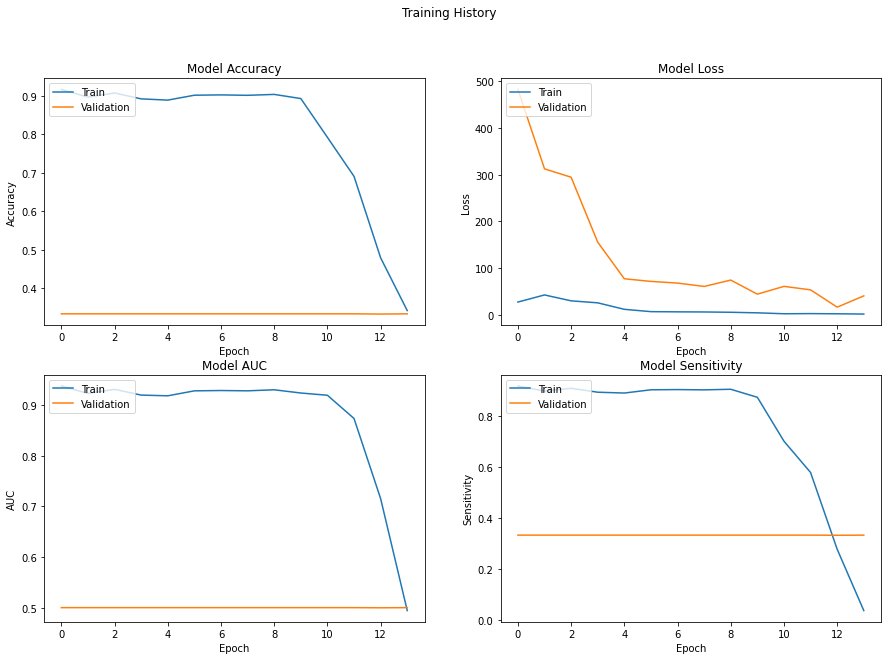

In [ ]:
plot_training_history(resnet50V2_bs32_img256_history)

### ResNet50V2 Training - Batch Size 16, Image Size 256
Result: Fast to Slow: Final Loss (Epoch 20): from 1.09918 to 1.09907.

In [ ]:
# Build the ResNet50V2 model
resnet50V2_bs16_img256 = build_model(
    base_model=resnet50V2_img256_base_model,
    is_trainable=False,
    model_name='resnet50',
    image_size=image_size
)

========================= MODEL SUMMARY =========================
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
resnet50V2_bs16_img256 = compile_model(
    resnet50V2_bs16_img256,
    tf.keras.optimizers.Adam(learning_rate=0.0001)
)

In [ ]:
resnet50V2_bs16_img256_history = train_model(
    model=resnet50V2_bs16_img256,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='resnet50_bs16_img256_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=batch_size
)

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 16.7661 - categorical_accuracy: 0.9860 - auc: 0.9896 - sensitivity: 0.9860
Epoch 1: val_loss improved from inf to 4517.55322, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 370s 391ms/step - loss: 16.7661 - categorical_accuracy: 0.9860 - auc: 0.9896 - sensitivity: 0.9860 - val_loss: 4517.5532 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 2/20
928/928 [==============================] - ETA: 0s - loss: 140.3105 - categorical_accuracy: 0.9500 - auc: 0.9626 - sensitivity: 0.9500
Epoch 2: val_loss improved from 4517.55322 to 1022.31604, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 356s 381ms/step - loss: 140.3105 - categorical_accuracy: 0.9500 - auc: 0.9626 - sensitivity: 0.9500 - val_loss: 1022.3160 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 3/20
928/928 [==============================] - ETA: 0s - loss: 37.4162 - categorical_accuracy: 0.9501 - auc: 0.9628 - sensitivity: 0.9501
Epoch 3: val_loss improved from 1022.31604 to 679.19794, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 358s 382ms/step - loss: 37.4162 - categorical_accuracy: 0.9501 - auc: 0.9628 - sensitivity: 0.9501 - val_loss: 679.1979 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 4/20
928/928 [==============================] - ETA: 0s - loss: 28.8795 - categorical_accuracy: 0.9493 - auc: 0.9622 - sensitivity: 0.9493
Epoch 4: val_loss improved from 679.19794 to 471.67361, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 360s 384ms/step - loss: 28.8795 - categorical_accuracy: 0.9493 - auc: 0.9622 - sensitivity: 0.9493 - val_loss: 471.6736 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 5/20
928/928 [==============================] - ETA: 0s - loss: 19.3114 - categorical_accuracy: 0.9549 - auc: 0.9662 - sensitivity: 0.9549
Epoch 5: val_loss improved from 471.67361 to 386.16956, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 357s 381ms/step - loss: 19.3114 - categorical_accuracy: 0.9549 - auc: 0.9662 - sensitivity: 0.9549 - val_loss: 386.1696 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 6/20
928/928 [==============================] - ETA: 0s - loss: 17.0104 - categorical_accuracy: 0.9512 - auc: 0.9638 - sensitivity: 0.9512
Epoch 6: val_loss improved from 386.16956 to 307.01221, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 358s 382ms/step - loss: 17.0104 - categorical_accuracy: 0.9512 - auc: 0.9638 - sensitivity: 0.9512 - val_loss: 307.0122 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 7/20
928/928 [==============================] - ETA: 0s - loss: 12.5884 - categorical_accuracy: 0.9480 - auc: 0.9613 - sensitivity: 0.9480
Epoch 7: val_loss improved from 307.01221 to 174.18694, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 356s 380ms/step - loss: 12.5884 - categorical_accuracy: 0.9480 - auc: 0.9613 - sensitivity: 0.9480 - val_loss: 174.1869 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 8/20
928/928 [==============================] - ETA: 0s - loss: 6.6783 - categorical_accuracy: 0.9521 - auc: 0.9649 - sensitivity: 0.9521
Epoch 8: val_loss improved from 174.18694 to 96.91491, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 352s 376ms/step - loss: 6.6783 - categorical_accuracy: 0.9521 - auc: 0.9649 - sensitivity: 0.9521 - val_loss: 96.9149 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 9/20
928/928 [==============================] - ETA: 0s - loss: 4.4176 - categorical_accuracy: 0.9375 - auc: 0.9570 - sensitivity: 0.9235
Epoch 9: val_loss did not improve from 96.91491
928/928 [==============================] - 331s 353ms/step - loss: 4.4176 - categorical_accuracy: 0.9375 - auc: 0.9570 - sensitivity: 0.9235 - val_loss: 100.3685 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 10/20
928/928 [==============================] - ETA: 0s - loss: 1.3632 - categorical_accuracy: 0.9262 - auc: 0.9763 - sensitivity: 0.9053
Epoch 10: val_loss did not improve from 96.91491
928/928 [==============================] - 333s 356ms/step - loss: 1.3632 - categorical_accuracy: 0.9262 - auc: 0.9763 - sensitivity:

928/928 [==============================] - 362s 387ms/step - loss: 5.1358 - categorical_accuracy: 0.8522 - auc: 0.9422 - sensitivity: 0.7458 - val_loss: 70.0363 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 12/20
928/928 [==============================] - ETA: 0s - loss: 1.8493 - categorical_accuracy: 0.8062 - auc: 0.9269 - sensitivity: 0.6576
Epoch 12: val_loss did not improve from 70.03629
928/928 [==============================] - 337s 359ms/step - loss: 1.8493 - categorical_accuracy: 0.8062 - auc: 0.9269 - sensitivity: 0.6576 - val_loss: 86.1325 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 13/20
928/928 [==============================] - ETA: 0s - loss: 3.7608 - categorical_accuracy: 0.8731 - auc: 0.9680 - sensitivity: 0.8725
Epoch 13: val_loss improved from 70.03629 to 54.61624, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 362s 386ms/step - loss: 3.7608 - categorical_accuracy: 0.8731 - auc: 0.9680 - sensitivity: 0.8725 - val_loss: 54.6162 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 14/20
928/928 [==============================] - ETA: 0s - loss: 2.1889 - categorical_accuracy: 0.6423 - auc: 0.8654 - sensitivity: 0.4585
Epoch 14: val_loss improved from 54.61624 to 5.27491, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 367s 392ms/step - loss: 2.1889 - categorical_accuracy: 0.6423 - auc: 0.8654 - sensitivity: 0.4585 - val_loss: 5.2749 - val_categorical_accuracy: 0.3333 - val_auc: 0.5047 - val_sensitivity: 0.3327
Epoch 15/20
928/928 [==============================] - ETA: 0s - loss: 1.4414 - categorical_accuracy: 0.5106 - auc: 0.7501 - sensitivity: 0.1909
Epoch 15: val_loss improved from 5.27491 to 1.09997, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 372s 398ms/step - loss: 1.4414 - categorical_accuracy: 0.5106 - auc: 0.7501 - sensitivity: 0.1909 - val_loss: 1.1000 - val_categorical_accuracy: 0.3339 - val_auc: 0.5006 - val_sensitivity: 6.0716e-04
Epoch 16/20
928/928 [==============================] - ETA: 0s - loss: 0.8852 - categorical_accuracy: 0.5331 - auc: 0.6502 - sensitivity: 0.1996
Epoch 16: val_loss did not improve from 1.09997
928/928 [==============================] - 332s 354ms/step - loss: 0.8852 - categorical_accuracy: 0.5331 - auc: 0.6502 - sensitivity: 0.1996 - val_loss: 98.4244 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 17/20
928/928 [==============================] - ETA: 0s - loss: 1.9923 - categorical_accuracy: 0.3762 - auc: 0.5142 - sensitivity: 0.0427
Epoch 17: val_loss did not improve from 1.09997
928/928 [==============================] - 328s 350ms/step - loss: 1.9923 - categorical_accuracy: 0.3762 - auc: 0.5142 - sensitivit

928/928 [==============================] - 359s 383ms/step - loss: 1.3441 - categorical_accuracy: 0.3333 - auc: 0.4794 - sensitivity: 0.0000e+00 - val_loss: 1.0993 - val_categorical_accuracy: 0.3339 - val_auc: 0.5006 - val_sensitivity: 6.0716e-04
Epoch 19/20
928/928 [==============================] - ETA: 0s - loss: 1.1008 - categorical_accuracy: 0.3333 - auc: 0.4789 - sensitivity: 0.0000e+00
Epoch 19: val_loss improved from 1.09930 to 1.09918, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 355s 379ms/step - loss: 1.1008 - categorical_accuracy: 0.3333 - auc: 0.4789 - sensitivity: 0.0000e+00 - val_loss: 1.0992 - val_categorical_accuracy: 0.3339 - val_auc: 0.5006 - val_sensitivity: 6.0716e-04
Epoch 20/20
928/928 [==============================] - ETA: 0s - loss: 1.1007 - categorical_accuracy: 0.3333 - auc: 0.4802 - sensitivity: 0.0000e+00
Epoch 20: val_loss improved from 1.09918 to 1.09907, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 355s 380ms/step - loss: 1.1007 - categorical_accuracy: 0.3333 - auc: 0.4802 - sensitivity: 0.0000e+00 - val_loss: 1.0991 - val_categorical_accuracy: 0.3339 - val_auc: 0.5006 - val_sensitivity: 6.0716e-04


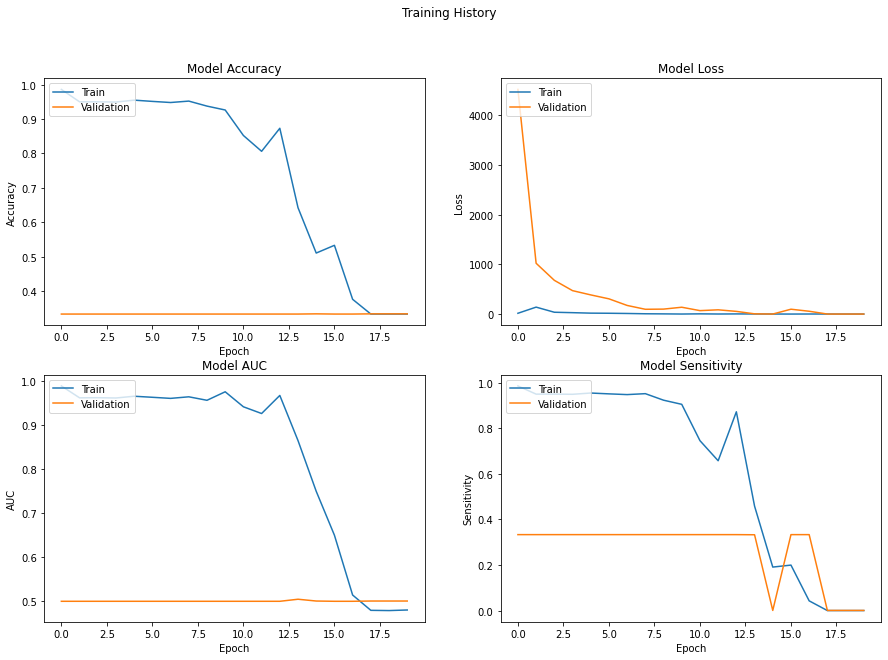

In [ ]:
plot_training_history(resnet50V2_bs16_img256_history)

### ResNet50V2 Training - Batch Size 16, Image Size 128
Result: Fast to Slow but plateaus for last 5 epochs: Final Loss (Epoch 20): 1.09874.

In [ ]:
# Create the ResNet50V2 base model
resnet50V2_img128_base_model = ResNet50V2(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(image_size, image_size, 3),
    classes=num_classes
)

In [ ]:
# Build the ResNet50V2 model
resnet50V2_bs16_img128 = build_model(
    base_model=resnet50V2_img128_base_model,
    is_trainable=False,
    model_name='resnet50',
    image_size=image_size
)

========================= MODEL SUMMARY =========================
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_6   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
resnet50V2_bs16_img128 = compile_model(
    resnet50V2_bs16_img128,
    tf.keras.optimizers.Adam(learning_rate=0.0001)
)

In [ ]:
resnet50V2_bs16_img128_history = train_model(
    model=resnet50V2_bs16_img128,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='resnet50_bs16_img128_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=batch_size
)

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 32.4781 - categorical_accuracy: 0.9871 - auc: 0.9903 - sensitivity: 0.9871
Epoch 1: val_loss improved from inf to 5877.00830, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 218s 227ms/step - loss: 32.4781 - categorical_accuracy: 0.9871 - auc: 0.9903 - sensitivity: 0.9871 - val_loss: 5877.0083 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 2/20
928/928 [==============================] - ETA: 0s - loss: 161.1331 - categorical_accuracy: 0.9504 - auc: 0.9628 - sensitivity: 0.9504
Epoch 2: val_loss improved from 5877.00830 to 1646.22375, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 207s 220ms/step - loss: 161.1331 - categorical_accuracy: 0.9504 - auc: 0.9628 - sensitivity: 0.9504 - val_loss: 1646.2238 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 3/20
928/928 [==============================] - ETA: 0s - loss: 55.1831 - categorical_accuracy: 0.9458 - auc: 0.9596 - sensitivity: 0.9458
Epoch 3: val_loss improved from 1646.22375 to 610.54285, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 209s 222ms/step - loss: 55.1831 - categorical_accuracy: 0.9458 - auc: 0.9596 - sensitivity: 0.9458 - val_loss: 610.5428 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 4/20
928/928 [==============================] - ETA: 0s - loss: 19.6687 - categorical_accuracy: 0.9571 - auc: 0.9680 - sensitivity: 0.9571
Epoch 4: val_loss improved from 610.54285 to 527.08069, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 207s 221ms/step - loss: 19.6687 - categorical_accuracy: 0.9571 - auc: 0.9680 - sensitivity: 0.9571 - val_loss: 527.0807 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 5/20
928/928 [==============================] - ETA: 0s - loss: 25.7059 - categorical_accuracy: 0.9456 - auc: 0.9594 - sensitivity: 0.9456
Epoch 5: val_loss improved from 527.08069 to 361.71436, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 208s 221ms/step - loss: 25.7059 - categorical_accuracy: 0.9456 - auc: 0.9594 - sensitivity: 0.9456 - val_loss: 361.7144 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 6/20
928/928 [==============================] - ETA: 0s - loss: 12.4296 - categorical_accuracy: 0.9556 - auc: 0.9669 - sensitivity: 0.9556
Epoch 6: val_loss did not improve from 361.71436
928/928 [==============================] - 184s 196ms/step - loss: 12.4296 - categorical_accuracy: 0.9556 - auc: 0.9669 - sensitivity: 0.9556 - val_loss: 388.5146 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 7/20
928/928 [==============================] - ETA: 0s - loss: 13.0358 - categorical_accuracy: 0.9509 - auc: 0.9635 - sensitivity: 0.9509
Epoch 7: val_loss improved from 361.71436 to 260.63647, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint

928/928 [==============================] - 209s 222ms/step - loss: 13.0358 - categorical_accuracy: 0.9509 - auc: 0.9635 - sensitivity: 0.9509 - val_loss: 260.6365 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 8/20
928/928 [==============================] - ETA: 0s - loss: 9.6600 - categorical_accuracy: 0.9540 - auc: 0.9659 - sensitivity: 0.9540
Epoch 8: val_loss improved from 260.63647 to 207.39073, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 208s 222ms/step - loss: 9.6600 - categorical_accuracy: 0.9540 - auc: 0.9659 - sensitivity: 0.9540 - val_loss: 207.3907 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 9/20
928/928 [==============================] - ETA: 0s - loss: 9.1147 - categorical_accuracy: 0.9484 - auc: 0.9622 - sensitivity: 0.9484
Epoch 9: val_loss improved from 207.39073 to 170.61777, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 210s 223ms/step - loss: 9.1147 - categorical_accuracy: 0.9484 - auc: 0.9622 - sensitivity: 0.9484 - val_loss: 170.6178 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 10/20
928/928 [==============================] - ETA: 0s - loss: 6.2718 - categorical_accuracy: 0.9356 - auc: 0.9525 - sensitivity: 0.9356
Epoch 10: val_loss improved from 170.61777 to 31.64430, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 210s 223ms/step - loss: 6.2718 - categorical_accuracy: 0.9356 - auc: 0.9525 - sensitivity: 0.9356 - val_loss: 31.6443 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 11/20
928/928 [==============================] - ETA: 0s - loss: 0.6374 - categorical_accuracy: 0.9172 - auc: 0.9723 - sensitivity: 0.8802
Epoch 11: val_loss did not improve from 31.64430
928/928 [==============================] - 189s 201ms/step - loss: 0.6374 - categorical_accuracy: 0.9172 - auc: 0.9723 - sensitivity: 0.8802 - val_loss: 78.5131 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 12/20
928/928 [==============================] - ETA: 0s - loss: 1.6997 - categorical_accuracy: 0.7203 - auc: 0.8948 - sensitivity: 0.5733
Epoch 12: val_loss improved from 31.64430 to 11.12132, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 206s 220ms/step - loss: 1.6997 - categorical_accuracy: 0.7203 - auc: 0.8948 - sensitivity: 0.5733 - val_loss: 11.1213 - val_categorical_accuracy: 0.3333 - val_auc: 0.5001 - val_sensitivity: 0.3333
Epoch 13/20
928/928 [==============================] - ETA: 0s - loss: 1.1719 - categorical_accuracy: 0.3245 - auc: 0.4646 - sensitivity: 3.3690e-04
Epoch 13: val_loss improved from 11.12132 to 1.09907, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 210s 224ms/step - loss: 1.1719 - categorical_accuracy: 0.3245 - auc: 0.4646 - sensitivity: 3.3690e-04 - val_loss: 1.0991 - val_categorical_accuracy: 0.3333 - val_auc: 0.4995 - val_sensitivity: 0.0000e+00
Epoch 14/20
928/928 [==============================] - ETA: 0s - loss: 1.1004 - categorical_accuracy: 0.3333 - auc: 0.4854 - sensitivity: 6.7381e-05
Epoch 14: val_loss improved from 1.09907 to 1.09875, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 207s 220ms/step - loss: 1.1004 - categorical_accuracy: 0.3333 - auc: 0.4854 - sensitivity: 6.7381e-05 - val_loss: 1.0987 - val_categorical_accuracy: 0.3333 - val_auc: 0.5001 - val_sensitivity: 0.0000e+00
Epoch 15/20
928/928 [==============================] - ETA: 0s - loss: 1.0998 - categorical_accuracy: 0.3335 - auc: 0.4887 - sensitivity: 1.3476e-04
Epoch 15: val_loss improved from 1.09875 to 1.09874, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 208s 222ms/step - loss: 1.0998 - categorical_accuracy: 0.3335 - auc: 0.4887 - sensitivity: 1.3476e-04 - val_loss: 1.0987 - val_categorical_accuracy: 0.3333 - val_auc: 0.4998 - val_sensitivity: 0.0000e+00
Epoch 16/20
928/928 [==============================] - ETA: 0s - loss: 1.1002 - categorical_accuracy: 0.3345 - auc: 0.4904 - sensitivity: 9.4333e-04
Epoch 16: val_loss did not improve from 1.09874
928/928 [==============================] - 184s 196ms/step - loss: 1.1002 - categorical_accuracy: 0.3345 - auc: 0.4904 - sensitivity: 9.4333e-04 - val_loss: 1.1066 - val_categorical_accuracy: 0.3315 - val_auc: 0.4990 - val_sensitivity: 6.0716e-04
Epoch 17/20
928/928 [==============================] - ETA: 0s - loss: 0.9548 - categorical_accuracy: 0.5469 - auc: 0.7576 - sensitivity: 0.2129
Epoch 17: val_loss did not improve from 1.09874
928/928 [==============================] - 184s 196ms/step - loss: 0.9548 - categorical_accuracy: 0.5469 - auc: 0.75

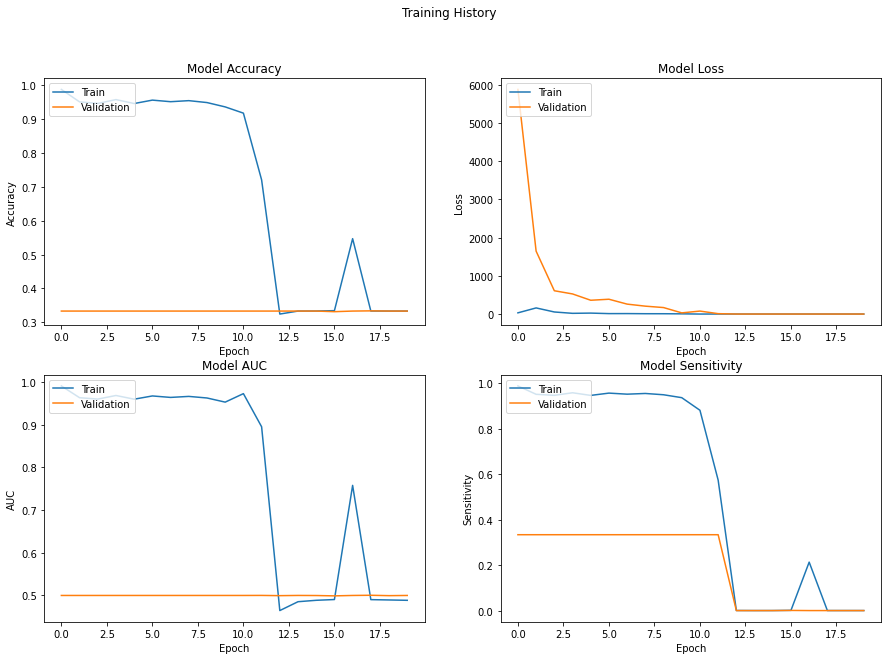

In [ ]:
plot_training_history(resnet50V2_bs16_img128_history)

### ResNet50V2 Training - Batch Size 32, Image Size 128
Fast so increased epochs but ultimately plateaus for 13 epochs at the end at 1.09812.

In [ ]:
# Build the ResNet50V2 model
resnet50V2_bs32_img128 = build_model(
    base_model=resnet50V2_img128_base_model,
    is_trainable=False,
    model_name='resnet50',
    image_size=image_size
)

========================= MODEL SUMMARY =========================
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_7   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
resnet50V2_bs32_img128 = compile_model(
    resnet50V2_bs32_img128,
    tf.keras.optimizers.Adam(learning_rate=0.0001)
)

In [ ]:
resnet50V2_bs32_img128_history = train_model(
    model=resnet50V2_bs32_img128,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='resnet50_bs32_img128_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=batch_size
)

Epoch 1/20
464/464 [==============================] - ETA: 0s - loss: 51.0790 - categorical_accuracy: 0.9739 - auc: 0.9805 - sensitivity: 0.9739
Epoch 1: val_loss improved from inf to 5497.56836, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 219s 456ms/step - loss: 51.0790 - categorical_accuracy: 0.9739 - auc: 0.9805 - sensitivity: 0.9739 - val_loss: 5497.5684 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 2/20
464/464 [==============================] - ETA: 0s - loss: 354.0595 - categorical_accuracy: 0.8965 - auc: 0.9225 - sensitivity: 0.8965
Epoch 2: val_loss improved from 5497.56836 to 1030.55530, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 209s 444ms/step - loss: 354.0595 - categorical_accuracy: 0.8965 - auc: 0.9225 - sensitivity: 0.8965 - val_loss: 1030.5553 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 3/20
464/464 [==============================] - ETA: 0s - loss: 83.7455 - categorical_accuracy: 0.9040 - auc: 0.9282 - sensitivity: 0.9040
Epoch 3: val_loss improved from 1030.55530 to 859.22260, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 209s 444ms/step - loss: 83.7455 - categorical_accuracy: 0.9040 - auc: 0.9282 - sensitivity: 0.9040 - val_loss: 859.2226 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 4/20
464/464 [==============================] - ETA: 0s - loss: 68.3852 - categorical_accuracy: 0.8997 - auc: 0.9250 - sensitivity: 0.8997
Epoch 4: val_loss improved from 859.22260 to 550.17499, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 210s 444ms/step - loss: 68.3852 - categorical_accuracy: 0.8997 - auc: 0.9250 - sensitivity: 0.8997 - val_loss: 550.1750 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 5/20
464/464 [==============================] - ETA: 0s - loss: 43.0889 - categorical_accuracy: 0.9057 - auc: 0.9295 - sensitivity: 0.9057
Epoch 5: val_loss improved from 550.17499 to 516.91998, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 209s 443ms/step - loss: 43.0889 - categorical_accuracy: 0.9057 - auc: 0.9295 - sensitivity: 0.9057 - val_loss: 516.9200 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 6/20
464/464 [==============================] - ETA: 0s - loss: 38.9646 - categorical_accuracy: 0.9042 - auc: 0.9283 - sensitivity: 0.9042
Epoch 6: val_loss improved from 516.91998 to 420.07642, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 208s 442ms/step - loss: 38.9646 - categorical_accuracy: 0.9042 - auc: 0.9283 - sensitivity: 0.9042 - val_loss: 420.0764 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 7/20
464/464 [==============================] - ETA: 0s - loss: 33.2447 - categorical_accuracy: 0.9050 - auc: 0.9293 - sensitivity: 0.9050
Epoch 7: val_loss improved from 420.07642 to 397.65289, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 207s 440ms/step - loss: 33.2447 - categorical_accuracy: 0.9050 - auc: 0.9293 - sensitivity: 0.9050 - val_loss: 397.6529 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 8/20
464/464 [==============================] - ETA: 0s - loss: 31.9152 - categorical_accuracy: 0.9030 - auc: 0.9276 - sensitivity: 0.9030
Epoch 8: val_loss improved from 397.65289 to 345.44345, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 207s 440ms/step - loss: 31.9152 - categorical_accuracy: 0.9030 - auc: 0.9276 - sensitivity: 0.9030 - val_loss: 345.4435 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 9/20
464/464 [==============================] - ETA: 0s - loss: 27.3170 - categorical_accuracy: 0.9002 - auc: 0.9257 - sensitivity: 0.9002
Epoch 9: val_loss improved from 345.44345 to 233.75734, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 208s 442ms/step - loss: 27.3170 - categorical_accuracy: 0.9002 - auc: 0.9257 - sensitivity: 0.9002 - val_loss: 233.7573 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 10/20
464/464 [==============================] - ETA: 0s - loss: 18.3672 - categorical_accuracy: 0.9047 - auc: 0.9294 - sensitivity: 0.9047
Epoch 10: val_loss improved from 233.75734 to 192.83502, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 210s 446ms/step - loss: 18.3672 - categorical_accuracy: 0.9047 - auc: 0.9294 - sensitivity: 0.9047 - val_loss: 192.8350 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 11/20
464/464 [==============================] - ETA: 0s - loss: 18.4230 - categorical_accuracy: 0.9040 - auc: 0.9290 - sensitivity: 0.9040
Epoch 11: val_loss improved from 192.83502 to 162.35097, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 208s 440ms/step - loss: 18.4230 - categorical_accuracy: 0.9040 - auc: 0.9290 - sensitivity: 0.9040 - val_loss: 162.3510 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 12/20
464/464 [==============================] - ETA: 0s - loss: 13.8201 - categorical_accuracy: 0.9043 - auc: 0.9291 - sensitivity: 0.9043
Epoch 12: val_loss improved from 162.35097 to 143.87883, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 207s 439ms/step - loss: 13.8201 - categorical_accuracy: 0.9043 - auc: 0.9291 - sensitivity: 0.9043 - val_loss: 143.8788 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 13/20
464/464 [==============================] - ETA: 0s - loss: 12.7266 - categorical_accuracy: 0.9028 - auc: 0.9288 - sensitivity: 0.9028
Epoch 13: val_loss improved from 143.87883 to 120.76048, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 209s 444ms/step - loss: 12.7266 - categorical_accuracy: 0.9028 - auc: 0.9288 - sensitivity: 0.9028 - val_loss: 120.7605 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 14/20
464/464 [==============================] - ETA: 0s - loss: 10.9557 - categorical_accuracy: 0.8991 - auc: 0.9257 - sensitivity: 0.8991
Epoch 14: val_loss improved from 120.76048 to 80.70762, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 210s 446ms/step - loss: 10.9557 - categorical_accuracy: 0.8991 - auc: 0.9257 - sensitivity: 0.8991 - val_loss: 80.7076 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 15/20
464/464 [==============================] - ETA: 0s - loss: 7.5570 - categorical_accuracy: 0.9082 - auc: 0.9333 - sensitivity: 0.9082
Epoch 15: val_loss improved from 80.70762 to 74.81284, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 208s 442ms/step - loss: 7.5570 - categorical_accuracy: 0.9082 - auc: 0.9333 - sensitivity: 0.9082 - val_loss: 74.8128 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 16/20
464/464 [==============================] - ETA: 0s - loss: 7.2329 - categorical_accuracy: 0.9029 - auc: 0.9294 - sensitivity: 0.9029
Epoch 16: val_loss improved from 74.81284 to 65.57882, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 213s 452ms/step - loss: 7.2329 - categorical_accuracy: 0.9029 - auc: 0.9294 - sensitivity: 0.9029 - val_loss: 65.5788 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 17/20
464/464 [==============================] - ETA: 0s - loss: 6.3192 - categorical_accuracy: 0.9068 - auc: 0.9322 - sensitivity: 0.9068
Epoch 17: val_loss improved from 65.57882 to 61.31025, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 207s 439ms/step - loss: 6.3192 - categorical_accuracy: 0.9068 - auc: 0.9322 - sensitivity: 0.9068 - val_loss: 61.3103 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 18/20
464/464 [==============================] - ETA: 0s - loss: 5.9865 - categorical_accuracy: 0.9058 - auc: 0.9318 - sensitivity: 0.9058
Epoch 18: val_loss improved from 61.31025 to 56.11171, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 208s 441ms/step - loss: 5.9865 - categorical_accuracy: 0.9058 - auc: 0.9318 - sensitivity: 0.9058 - val_loss: 56.1117 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 19/20
464/464 [==============================] - ETA: 0s - loss: 5.5008 - categorical_accuracy: 0.9057 - auc: 0.9325 - sensitivity: 0.9057
Epoch 19: val_loss improved from 56.11171 to 51.78317, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 207s 440ms/step - loss: 5.5008 - categorical_accuracy: 0.9057 - auc: 0.9325 - sensitivity: 0.9057 - val_loss: 51.7832 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 20/20
464/464 [==============================] - ETA: 0s - loss: 5.1558 - categorical_accuracy: 0.9034 - auc: 0.9311 - sensitivity: 0.9034
Epoch 20: val_loss improved from 51.78317 to 45.24998, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 206s 439ms/step - loss: 5.1558 - categorical_accuracy: 0.9034 - auc: 0.9311 - sensitivity: 0.9034 - val_loss: 45.2500 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333


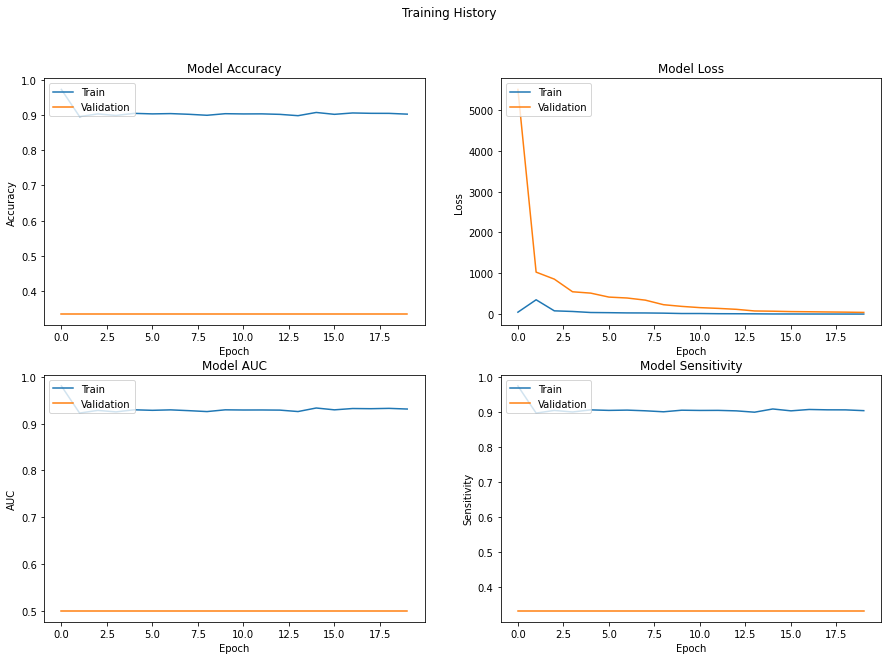

In [ ]:
plot_training_history(resnet50V2_bs32_img128_history)

In [ ]:
resnet50V2_bs32_img128_history2 = train_model(
    model=resnet50V2_bs32_img128,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='resnet50_bs32_img128_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=50,
    initial_epoch=20,
    batch_size=batch_size,
    initial_value_threshold=45.24998
)

Epoch 21/50
464/464 [==============================] - ETA: 0s - loss: 4.5914 - categorical_accuracy: 0.8851 - auc: 0.9192 - sensitivity: 0.8824
Epoch 21: val_loss did not improve from 45.24998
464/464 [==============================] - 183s 388ms/step - loss: 4.5914 - categorical_accuracy: 0.8851 - auc: 0.9192 - sensitivity: 0.8824 - val_loss: 64.3292 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 22/50
464/464 [==============================] - ETA: 0s - loss: 2.5056 - categorical_accuracy: 0.8421 - auc: 0.9363 - sensitivity: 0.8182
Epoch 22: val_loss improved from 45.24998 to 37.62562, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 208s 441ms/step - loss: 2.5056 - categorical_accuracy: 0.8421 - auc: 0.9363 - sensitivity: 0.8182 - val_loss: 37.6256 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 23/50
464/464 [==============================] - ETA: 0s - loss: 3.0057 - categorical_accuracy: 0.8548 - auc: 0.9437 - sensitivity: 0.8072
Epoch 23: val_loss did not improve from 37.62562
464/464 [==============================] - 182s 386ms/step - loss: 3.0057 - categorical_accuracy: 0.8548 - auc: 0.9437 - sensitivity: 0.8072 - val_loss: 94.2315 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 24/50
464/464 [==============================] - ETA: 0s - loss: 4.1297 - categorical_accuracy: 0.7473 - auc: 0.8953 - sensitivity: 0.6574
Epoch 24: val_loss did not improve from 37.62562
464/464 [==============================] - 183s 388ms/step - loss: 4.1297 - categorical_accuracy: 0.7473 - auc: 0.8953 - sensitivity

464/464 [==============================] - 209s 444ms/step - loss: 3.2084 - categorical_accuracy: 0.4052 - auc: 0.5763 - sensitivity: 0.1100 - val_loss: 8.3320 - val_categorical_accuracy: 0.3327 - val_auc: 0.5010 - val_sensitivity: 0.3321
Epoch 29/50
464/464 [==============================] - ETA: 0s - loss: 1.0806 - categorical_accuracy: 0.3690 - auc: 0.5252 - sensitivity: 0.0441
Epoch 29: val_loss did not improve from 8.33201
464/464 [==============================] - 184s 389ms/step - loss: 1.0806 - categorical_accuracy: 0.3690 - auc: 0.5252 - sensitivity: 0.0441 - val_loss: 41.9064 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 30/50
464/464 [==============================] - ETA: 0s - loss: 1.4697 - categorical_accuracy: 0.3087 - auc: 0.4607 - sensitivity: 3.3690e-04
Epoch 30: val_loss improved from 8.33201 to 1.09835, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 208s 441ms/step - loss: 1.4697 - categorical_accuracy: 0.3087 - auc: 0.4607 - sensitivity: 3.3690e-04 - val_loss: 1.0984 - val_categorical_accuracy: 0.3339 - val_auc: 0.5005 - val_sensitivity: 6.0716e-04
Epoch 31/50
464/464 [==============================] - ETA: 0s - loss: 1.0991 - categorical_accuracy: 0.3345 - auc: 0.4793 - sensitivity: 0.0011    
Epoch 31: val_loss did not improve from 1.09835
464/464 [==============================] - 181s 384ms/step - loss: 1.0991 - categorical_accuracy: 0.3345 - auc: 0.4793 - sensitivity: 0.0011 - val_loss: 4.3619 - val_categorical_accuracy: 0.3175 - val_auc: 0.4964 - val_sensitivity: 0.2902
Epoch 32/50
464/464 [==============================] - ETA: 0s - loss: 0.9101 - categorical_accuracy: 0.4990 - auc: 0.6908 - sensitivity: 0.1713
Epoch 32: val_loss did not improve from 1.09835
464/464 [==============================] - 182s 385ms/step - loss: 0.9101 - categorical_accuracy: 0.4990 - auc: 0.6908 - sen

464/464 [==============================] - 208s 442ms/step - loss: 1.1140 - categorical_accuracy: 0.3303 - auc: 0.4813 - sensitivity: 4.7167e-04 - val_loss: 1.0982 - val_categorical_accuracy: 0.3339 - val_auc: 0.5009 - val_sensitivity: 6.0716e-04
Epoch 35/50
464/464 [==============================] - ETA: 0s - loss: 1.0543 - categorical_accuracy: 0.3741 - auc: 0.5377 - sensitivity: 0.0407
Epoch 35: val_loss did not improve from 1.09823
464/464 [==============================] - 183s 387ms/step - loss: 1.0543 - categorical_accuracy: 0.3741 - auc: 0.5377 - sensitivity: 0.0407 - val_loss: 124.3430 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 36/50
464/464 [==============================] - ETA: 0s - loss: 3.0900 - categorical_accuracy: 0.3154 - auc: 0.4704 - sensitivity: 6.0643e-04
Epoch 36: val_loss improved from 1.09823 to 1.09820, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkp

464/464 [==============================] - 213s 452ms/step - loss: 3.0900 - categorical_accuracy: 0.3154 - auc: 0.4704 - sensitivity: 6.0643e-04 - val_loss: 1.0982 - val_categorical_accuracy: 0.3339 - val_auc: 0.5009 - val_sensitivity: 6.0716e-04
Epoch 37/50
464/464 [==============================] - ETA: 0s - loss: 1.0994 - categorical_accuracy: 0.3339 - auc: 0.4856 - sensitivity: 6.7381e-04
Epoch 37: val_loss improved from 1.09820 to 1.09812, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/resnet50_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 209s 443ms/step - loss: 1.0994 - categorical_accuracy: 0.3339 - auc: 0.4856 - sensitivity: 6.7381e-04 - val_loss: 1.0981 - val_categorical_accuracy: 0.3339 - val_auc: 0.5015 - val_sensitivity: 6.0716e-04
Epoch 38/50
464/464 [==============================] - ETA: 0s - loss: 3.3939 - categorical_accuracy: 0.3829 - auc: 0.5847 - sensitivity: 0.1306
Epoch 38: val_loss did not improve from 1.09812
464/464 [==============================] - 183s 388ms/step - loss: 3.3939 - categorical_accuracy: 0.3829 - auc: 0.5847 - sensitivity: 0.1306 - val_loss: 1.0982 - val_categorical_accuracy: 0.3339 - val_auc: 0.5009 - val_sensitivity: 6.0716e-04
Epoch 39/50
464/464 [==============================] - ETA: 0s - loss: 0.9298 - categorical_accuracy: 0.4420 - auc: 0.6657 - sensitivity: 0.1514
Epoch 39: val_loss did not improve from 1.09812
464/464 [==============================] - 184s 389ms/step - loss: 0.9298 - categorical_accuracy: 0.4420 - auc: 0.6657 - sen

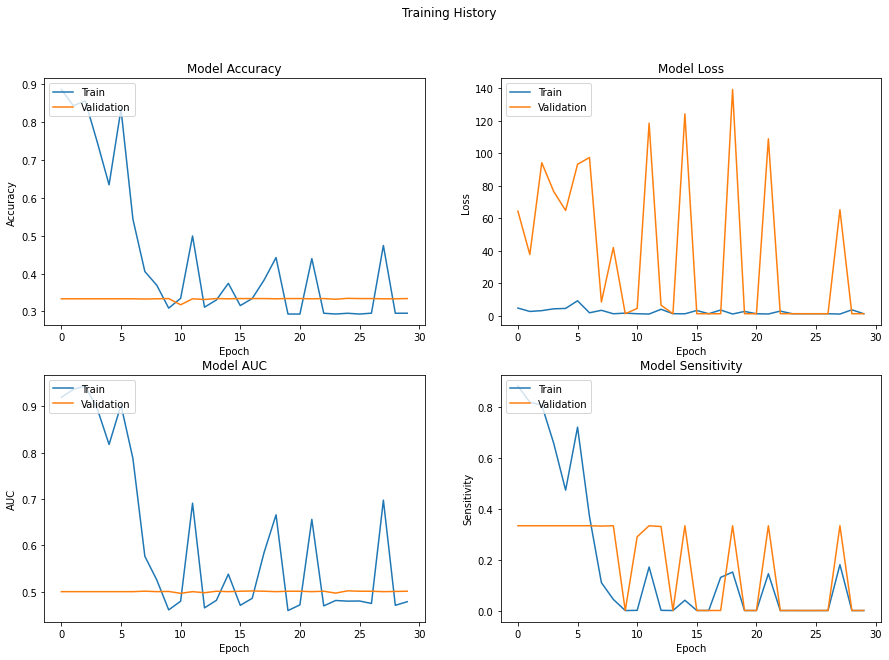

In [ ]:
plot_training_history(resnet50V2_bs32_img128_history2)

In [ ]:
experimentsV1_history = dict()
experimentsV1_history['resnet50V2_bs32_img256_history'] = resnet50V2_bs32_img256_history.history
experimentsV1_history['resnet50V2_bs16_img256_history'] = resnet50V2_bs16_img256_history.history
experimentsV1_history['resnet50V2_bs16_img128_history'] = resnet50V2_bs16_img128_history.history
experimentsV1_history['resnet50V2_bs32_img128_history'] = resnet50V2_bs32_img128_history.history
experimentsV1_history['resnet50V2_bs32_img128_history2'] = resnet50V2_bs32_img128_history2.history

# Save dictionary to npz file
np.savez(os.path.join(root_dir, 'experimentsV1_history.npz'), **experimentsV1_history)

## EfficientNetB3 Training with CrossEntropy Loss

### EfficientNetB3 Training - Batch Size 32, Image Size 256

In [ ]:
# Create training, validation and test tensorflow data generators
train_datagen, validation_datagen, test_datagen = create_data_generators(batch_size=32, image_size=256)

Found 14841 images belonging to 3 classes.
Found 1647 images belonging to 3 classes.
Found 4122 images belonging to 3 classes.


In [ ]:
# Create the EfficientNetV2B3 base model
efficientnetV2B3_img256_base_model = EfficientNetV2B3(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(256, 256, 3),
    classes=num_classes,
    include_preprocessing=True
)

In [ ]:
# Build the EfficientNetV2B3 model
efficientnetV2B3_bs32_img256 = build_model(
    base_model=efficientnetV2B3_img256_base_model,
    is_trainable=False,
    model_name='efficientnet',
    image_size=256
)

efficientnetV2B3_bs32_img256 = compile_model(
    efficientnetV2B3_bs32_img256,
    tf.keras.optimizers.Adam(learning_rate=0.0001)
)

========================= MODEL SUMMARY =========================
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, 8, 8, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                             

In [ ]:
efficientnetV2B3_bs32_img256_history = train_model(
    model=efficientnetV2B3_bs32_img256,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='efficientnetV2B3_bs32_img256_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=32
)

Epoch 1/20
464/464 [==============================] - ETA: 0s - loss: 0.2749 - categorical_accuracy: 0.9508 - auc: 0.9791 - sensitivity: 0.9495
Epoch 1: val_loss improved from inf to 8.05186, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs32_img256_trainableFalse/checkpoint


464/464 [==============================] - 364s 758ms/step - loss: 0.2749 - categorical_accuracy: 0.9508 - auc: 0.9791 - sensitivity: 0.9495 - val_loss: 8.0519 - val_categorical_accuracy: 0.3333 - val_auc: 0.4999 - val_sensitivity: 0.3333
Epoch 2/20
464/464 [==============================] - ETA: 0s - loss: 0.7117 - categorical_accuracy: 0.8679 - auc: 0.9294 - sensitivity: 0.8587
Epoch 2: val_loss improved from 8.05186 to 4.71763, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs32_img256_trainableFalse/checkpoint


464/464 [==============================] - 340s 728ms/step - loss: 0.7117 - categorical_accuracy: 0.8679 - auc: 0.9294 - sensitivity: 0.8587 - val_loss: 4.7176 - val_categorical_accuracy: 0.3333 - val_auc: 0.5160 - val_sensitivity: 0.3333
Epoch 3/20
464/464 [==============================] - ETA: 0s - loss: 0.6903 - categorical_accuracy: 0.8014 - auc: 0.9007 - sensitivity: 0.7882
Epoch 3: val_loss improved from 4.71763 to 3.54663, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs32_img256_trainableFalse/checkpoint


464/464 [==============================] - 342s 731ms/step - loss: 0.6903 - categorical_accuracy: 0.8014 - auc: 0.9007 - sensitivity: 0.7882 - val_loss: 3.5466 - val_categorical_accuracy: 0.3333 - val_auc: 0.5564 - val_sensitivity: 0.3333
Epoch 4/20
464/464 [==============================] - ETA: 0s - loss: 0.7006 - categorical_accuracy: 0.7820 - auc: 0.9007 - sensitivity: 0.7592
Epoch 4: val_loss did not improve from 3.54663
464/464 [==============================] - 257s 548ms/step - loss: 0.7006 - categorical_accuracy: 0.7820 - auc: 0.9007 - sensitivity: 0.7592 - val_loss: 3.5526 - val_categorical_accuracy: 0.3333 - val_auc: 0.5665 - val_sensitivity: 0.3333
Epoch 5/20
464/464 [==============================] - ETA: 0s - loss: 0.7248 - categorical_accuracy: 0.7697 - auc: 0.8919 - sensitivity: 0.7389
Epoch 5: val_loss improved from 3.54663 to 3.06226, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs32_img256_trainableFalse/checkpoint


464/464 [==============================] - 335s 716ms/step - loss: 0.7248 - categorical_accuracy: 0.7697 - auc: 0.8919 - sensitivity: 0.7389 - val_loss: 3.0623 - val_categorical_accuracy: 0.3333 - val_auc: 0.5869 - val_sensitivity: 0.3333
Epoch 6/20
464/464 [==============================] - ETA: 0s - loss: 0.7198 - categorical_accuracy: 0.7696 - auc: 0.8994 - sensitivity: 0.7387
Epoch 6: val_loss did not improve from 3.06226
464/464 [==============================] - 255s 543ms/step - loss: 0.7198 - categorical_accuracy: 0.7696 - auc: 0.8994 - sensitivity: 0.7387 - val_loss: 4.0769 - val_categorical_accuracy: 0.3333 - val_auc: 0.5444 - val_sensitivity: 0.3333
Epoch 7/20
464/464 [==============================] - ETA: 0s - loss: 0.7188 - categorical_accuracy: 0.7937 - auc: 0.8992 - sensitivity: 0.7675
Epoch 7: val_loss did not improve from 3.06226
464/464 [==============================] - 255s 542ms/step - loss: 0.7188 - categorical_accuracy: 0.7937 - auc: 0.8992 - sensitivity: 0.7675

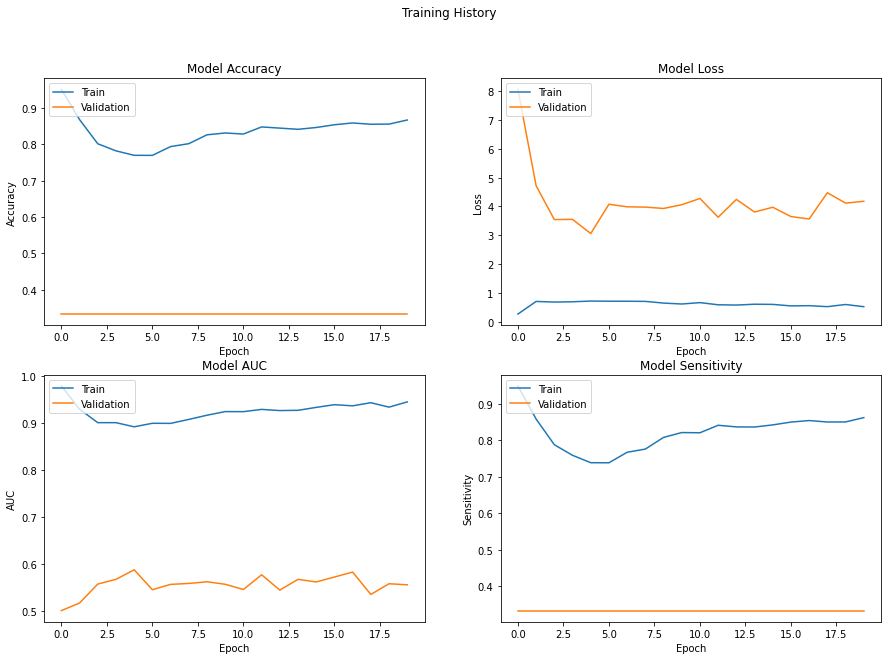

In [ ]:
plot_training_history(efficientnetV2B3_bs32_img256_history)

In [ ]:
efficientnetV2B3_bs32_img256 = load_model(outputs_dir, 'efficientnetV2B3_bs32_img256_trainableFalse')

In [ ]:
experimentsV1_history2 = dict()
# experimentsV1_history['resnet50V2_bs32_img256_history'] = resnet50V2_bs32_img256_history.history
# experimentsV1_history['resnet50V2_bs16_img256_history'] = resnet50V2_bs16_img256_history.history
# experimentsV1_history['resnet50V2_bs16_img128_history'] = resnet50V2_bs16_img128_history.history
# experimentsV1_history['resnet50V2_bs32_img128_history'] = resnet50V2_bs32_img128_history.history
# experimentsV1_history['resnet50V2_bs32_img128_history2'] = resnet50V2_bs32_img128_history2.history
experimentsV1_history2['efficientnetV2B3_bs32_img256_history'] = efficientnetV2B3_bs32_img256_history.history

# Save dictionary to npz file
np.savez(os.path.join(root_dir, 'experimentsV1_history2.npz'), **experimentsV1_history2)

### EfficientNetB3 Training - Batch Size 16, Image Size 256
Got disconnected at epoch 19, but before then plateaued for 8 epochs at loss of 4.33023

In [ ]:
# Create training, validation and test tensorflow data generators
train_datagen, validation_datagen, test_datagen = create_data_generators(batch_size=16, image_size=256)

Found 14841 images belonging to 3 classes.
Found 1647 images belonging to 3 classes.
Found 4122 images belonging to 3 classes.


In [ ]:
# Build the EfficientNetV2B3 model
efficientnetV2B3_bs16_img256 = build_model(
    base_model=efficientnetV2B3_img256_base_model,
    is_trainable=False,
    model_name='efficientnet',
    image_size=256
)

efficientnetV2B3_bs16_img256 = compile_model(
    efficientnetV2B3_bs16_img256,
    tf.keras.optimizers.Adam(learning_rate=0.0001)
)

========================= MODEL SUMMARY =========================
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, 8, 8, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               786944    
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                           

In [ ]:
efficientnetV2B3_bs16_img256_history = train_model(
    model=efficientnetV2B3_bs16_img256,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='efficientnetV2B3_bs16_img256_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=16
)

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 0.1776 - categorical_accuracy: 0.9763 - auc: 0.9890 - sensitivity: 0.9749
Epoch 1: val_loss improved from inf to 7.90746, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 374s 383ms/step - loss: 0.1776 - categorical_accuracy: 0.9763 - auc: 0.9890 - sensitivity: 0.9749 - val_loss: 7.9075 - val_categorical_accuracy: 0.3333 - val_auc: 0.4998 - val_sensitivity: 0.3333
Epoch 2/20
928/928 [==============================] - ETA: 0s - loss: 0.4208 - categorical_accuracy: 0.9253 - auc: 0.9663 - sensitivity: 0.9236
Epoch 2: val_loss improved from 7.90746 to 4.75955, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 347s 371ms/step - loss: 0.4208 - categorical_accuracy: 0.9253 - auc: 0.9663 - sensitivity: 0.9236 - val_loss: 4.7595 - val_categorical_accuracy: 0.3333 - val_auc: 0.5083 - val_sensitivity: 0.3333
Epoch 3/20
928/928 [==============================] - ETA: 0s - loss: 0.3842 - categorical_accuracy: 0.9074 - auc: 0.9638 - sensitivity: 0.9040
Epoch 3: val_loss improved from 4.75955 to 4.68622, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 350s 374ms/step - loss: 0.3842 - categorical_accuracy: 0.9074 - auc: 0.9638 - sensitivity: 0.9040 - val_loss: 4.6862 - val_categorical_accuracy: 0.3333 - val_auc: 0.5072 - val_sensitivity: 0.3333
Epoch 4/20
928/928 [==============================] - ETA: 0s - loss: 0.3640 - categorical_accuracy: 0.9121 - auc: 0.9672 - sensitivity: 0.9085
Epoch 4: val_loss did not improve from 4.68622
928/928 [==============================] - 262s 279ms/step - loss: 0.3640 - categorical_accuracy: 0.9121 - auc: 0.9672 - sensitivity: 0.9085 - val_loss: 5.0319 - val_categorical_accuracy: 0.3333 - val_auc: 0.5049 - val_sensitivity: 0.3333
Epoch 5/20
928/928 [==============================] - ETA: 0s - loss: 0.3423 - categorical_accuracy: 0.9176 - auc: 0.9700 - sensitivity: 0.9160
Epoch 5: val_loss improved from 4.68622 to 4.65022, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 349s 373ms/step - loss: 0.3423 - categorical_accuracy: 0.9176 - auc: 0.9700 - sensitivity: 0.9160 - val_loss: 4.6502 - val_categorical_accuracy: 0.3333 - val_auc: 0.5084 - val_sensitivity: 0.3333
Epoch 6/20
928/928 [==============================] - ETA: 0s - loss: 0.3446 - categorical_accuracy: 0.9212 - auc: 0.9718 - sensitivity: 0.9199
Epoch 6: val_loss improved from 4.65022 to 4.63879, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 348s 372ms/step - loss: 0.3446 - categorical_accuracy: 0.9212 - auc: 0.9718 - sensitivity: 0.9199 - val_loss: 4.6388 - val_categorical_accuracy: 0.3333 - val_auc: 0.5156 - val_sensitivity: 0.3333
Epoch 7/20
928/928 [==============================] - ETA: 0s - loss: 0.3039 - categorical_accuracy: 0.9307 - auc: 0.9762 - sensitivity: 0.9296
Epoch 7: val_loss did not improve from 4.63879
928/928 [==============================] - 269s 286ms/step - loss: 0.3039 - categorical_accuracy: 0.9307 - auc: 0.9762 - sensitivity: 0.9296 - val_loss: 5.0554 - val_categorical_accuracy: 0.3333 - val_auc: 0.5042 - val_sensitivity: 0.3333
Epoch 8/20
928/928 [==============================] - ETA: 0s - loss: 0.3327 - categorical_accuracy: 0.9272 - auc: 0.9728 - sensitivity: 0.9265
Epoch 8: val_loss did not improve from 4.63879
928/928 [==============================] - 271s 289ms/step - loss: 0.3327 - categorical_accuracy: 0.9272 - auc: 0.9728 - sensitivity: 0.9265

928/928 [==============================] - 369s 395ms/step - loss: 0.3155 - categorical_accuracy: 0.9308 - auc: 0.9742 - sensitivity: 0.9289 - val_loss: 4.3302 - val_categorical_accuracy: 0.3333 - val_auc: 0.5367 - val_sensitivity: 0.3333
Epoch 11/20
928/928 [==============================] - ETA: 0s - loss: 0.3197 - categorical_accuracy: 0.9274 - auc: 0.9742 - sensitivity: 0.9251
Epoch 11: val_loss did not improve from 4.33023
928/928 [==============================] - 278s 297ms/step - loss: 0.3197 - categorical_accuracy: 0.9274 - auc: 0.9742 - sensitivity: 0.9251 - val_loss: 5.6301 - val_categorical_accuracy: 0.3333 - val_auc: 0.5017 - val_sensitivity: 0.3333
Epoch 12/20
928/928 [==============================] - ETA: 0s - loss: 0.3373 - categorical_accuracy: 0.9266 - auc: 0.9719 - sensitivity: 0.9253
Epoch 12: val_loss did not improve from 4.33023
928/928 [==============================] - 280s 299ms/step - loss: 0.3373 - categorical_accuracy: 0.9266 - auc: 0.9719 - sensitivity: 0.

In [ ]:
plot_training_history(efficientnetV2B3_bs16_img256_history)

### EfficientNetB3 Training - Batch Size 16, Image Size 128

In [ ]:
# Create training, validation and test tensorflow data generators
train_datagen, validation_datagen, test_datagen = create_data_generators(batch_size=16, image_size=128)

Found 14841 images belonging to 3 classes.
Found 1647 images belonging to 3 classes.
Found 4122 images belonging to 3 classes.


In [ ]:
# Create the EfficientNetV2B3 base model
efficientnetV2B3_img128_base_model = EfficientNetV2B3(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(128, 128, 3),
    classes=num_classes,
    include_preprocessing=True
)

# Build the EfficientNetV2B3 model
efficientnetV2B3_bs16_img128 = build_model(
    base_model=efficientnetV2B3_img128_base_model,
    is_trainable=False,
    model_name='efficientnet',
    image_size=128
)

efficientnetV2B3_bs16_img128 = compile_model(
    efficientnetV2B3_bs16_img128,
    tf.keras.optimizers.Adam(learning_rate=0.0001)
)

52606240/52606240 [==============================] - 0s 0us/step
========================= MODEL SUMMARY =========================
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, 4, 4, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 3)                 1539   

In [ ]:
efficientnetV2B3_bs16_img128_history = train_model(
    model=efficientnetV2B3_bs16_img128,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='efficientnetV2B3_bs16_img128_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=16
)

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 0.1542 - categorical_accuracy: 0.9762 - auc: 0.9894 - sensitivity: 0.9751
Epoch 1: val_loss improved from inf to 8.56203, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 1077s 1s/step - loss: 0.1542 - categorical_accuracy: 0.9762 - auc: 0.9894 - sensitivity: 0.9751 - val_loss: 8.5620 - val_categorical_accuracy: 0.3333 - val_auc: 0.5001 - val_sensitivity: 0.3333
Epoch 2/20
928/928 [==============================] - ETA: 0s - loss: 0.4361 - categorical_accuracy: 0.9230 - auc: 0.9652 - sensitivity: 0.9210
Epoch 2: val_loss improved from 8.56203 to 4.85086, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 276s 296ms/step - loss: 0.4361 - categorical_accuracy: 0.9230 - auc: 0.9652 - sensitivity: 0.9210 - val_loss: 4.8509 - val_categorical_accuracy: 0.3333 - val_auc: 0.5042 - val_sensitivity: 0.3333
Epoch 3/20
928/928 [==============================] - ETA: 0s - loss: 0.3924 - categorical_accuracy: 0.9005 - auc: 0.9624 - sensitivity: 0.8900
Epoch 3: val_loss improved from 4.85086 to 4.70544, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 270s 289ms/step - loss: 0.3924 - categorical_accuracy: 0.9005 - auc: 0.9624 - sensitivity: 0.8900 - val_loss: 4.7054 - val_categorical_accuracy: 0.3333 - val_auc: 0.5105 - val_sensitivity: 0.3333
Epoch 4/20
928/928 [==============================] - ETA: 0s - loss: 0.4051 - categorical_accuracy: 0.8865 - auc: 0.9632 - sensitivity: 0.8756
Epoch 4: val_loss did not improve from 4.70544
928/928 [==============================] - 185s 197ms/step - loss: 0.4051 - categorical_accuracy: 0.8865 - auc: 0.9632 - sensitivity: 0.8756 - val_loss: 5.2909 - val_categorical_accuracy: 0.3333 - val_auc: 0.5018 - val_sensitivity: 0.3333
Epoch 5/20
928/928 [==============================] - ETA: 0s - loss: 0.3876 - categorical_accuracy: 0.8964 - auc: 0.9647 - sensitivity: 0.8883
Epoch 5: val_loss did not improve from 4.70544
928/928 [==============================] - 180s 191ms/step - loss: 0.3876 - categorical_accuracy: 0.8964 - auc: 0.9647 - sensitivity: 0.8883

928/928 [==============================] - 256s 274ms/step - loss: 0.2587 - categorical_accuracy: 0.9419 - auc: 0.9803 - sensitivity: 0.9407 - val_loss: 4.6407 - val_categorical_accuracy: 0.3333 - val_auc: 0.5132 - val_sensitivity: 0.3333
Epoch 20/20
928/928 [==============================] - ETA: 0s - loss: 0.2204 - categorical_accuracy: 0.9445 - auc: 0.9844 - sensitivity: 0.9435
Epoch 20: val_loss did not improve from 4.64067
928/928 [==============================] - 166s 177ms/step - loss: 0.2204 - categorical_accuracy: 0.9445 - auc: 0.9844 - sensitivity: 0.9435 - val_loss: 4.9470 - val_categorical_accuracy: 0.3333 - val_auc: 0.5113 - val_sensitivity: 0.3333


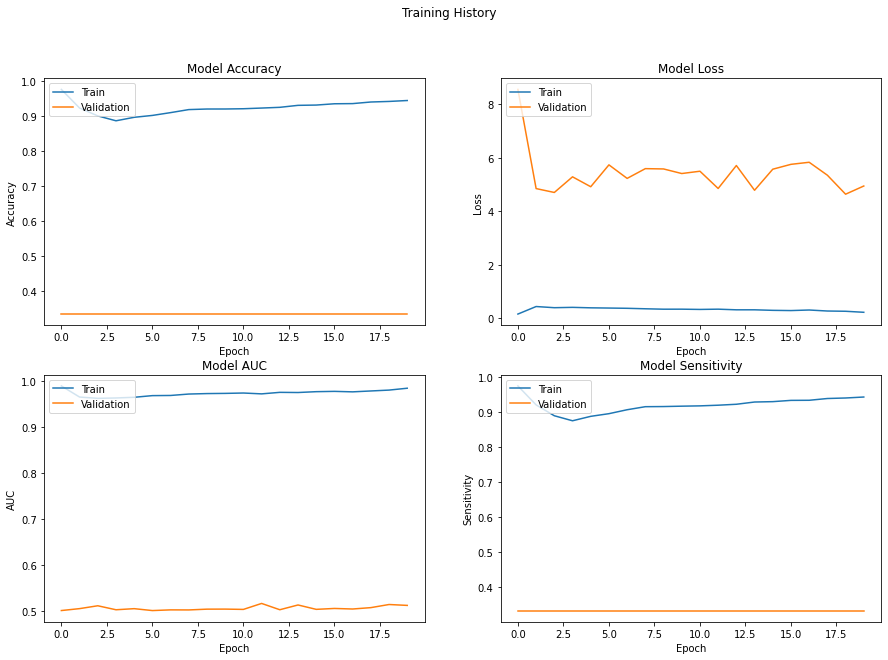

In [ ]:
plot_training_history(efficientnetV2B3_bs16_img128_history)

In [ ]:
experimentsV1_history2 = dict()
# experimentsV1_history['resnet50V2_bs32_img256_history'] = resnet50V2_bs32_img256_history.history
# experimentsV1_history['resnet50V2_bs16_img256_history'] = resnet50V2_bs16_img256_history.history
# experimentsV1_history['resnet50V2_bs16_img128_history'] = resnet50V2_bs16_img128_history.history
# experimentsV1_history['resnet50V2_bs32_img128_history'] = resnet50V2_bs32_img128_history.history
# experimentsV1_history['resnet50V2_bs32_img128_history2'] = resnet50V2_bs32_img128_history2.history
experimentsV1_history2['efficientnetV2B3_bs32_img256_history'] = efficientnetV2B3_bs32_img256_history.history
experimentsV1_history2['efficientnetV2B3_bs16_img256_history'] = efficientnetV2B3_bs16_img256_history.history
experimentsV1_history2['efficientnetV2B3_bs16_img128_history'] = efficientnetV2B3_bs16_img128_history.history

# Save dictionary to npz file
np.savez(os.path.join(root_dir, 'experimentsV1_history2.npz'), **experimentsV1_history2)

### EfficientNetB3 Training - Batch Size 32, Image Size 128

In [ ]:
# Create training, validation and test tensorflow data generators
train_datagen, validation_datagen, test_datagen = create_data_generators(batch_size=32, image_size=128)

Found 14841 images belonging to 3 classes.
Found 1647 images belonging to 3 classes.
Found 4122 images belonging to 3 classes.


In [ ]:
# Create the EfficientNetV2B3 base model
efficientnetV2B3_img128_base_model = EfficientNetV2B3(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(128, 128, 3),
    classes=num_classes,
    include_preprocessing=True
)

# Build the EfficientNetV2B3 model
efficientnetV2B3_bs32_img128 = build_model(
    base_model=efficientnetV2B3_img128_base_model,
    is_trainable=False,
    model_name='efficientnet',
    image_size=128
)

efficientnetV2B3_bs32_img128 = compile_model(
    efficientnetV2B3_bs32_img128,
    tf.keras.optimizers.Adam(learning_rate=0.0001)
)

========================= MODEL SUMMARY =========================
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, 4, 4, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               786944    
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                           

In [ ]:
efficientnetV2B3_bs32_img128_history = train_model(
    model=efficientnetV2B3_bs32_img128,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='efficientnetV2B3_bs32_img128_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=32
)

Epoch 1/20
464/464 [==============================] - ETA: 0s - loss: 0.2969 - categorical_accuracy: 0.9472 - auc: 0.9771 - sensitivity: 0.9443
Epoch 1: val_loss improved from inf to 7.63070, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 242s 483ms/step - loss: 0.2969 - categorical_accuracy: 0.9472 - auc: 0.9771 - sensitivity: 0.9443 - val_loss: 7.6307 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 2/20
464/464 [==============================] - ETA: 0s - loss: 0.6867 - categorical_accuracy: 0.8645 - auc: 0.9236 - sensitivity: 0.8595
Epoch 2: val_loss improved from 7.63070 to 4.20755, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 217s 464ms/step - loss: 0.6867 - categorical_accuracy: 0.8645 - auc: 0.9236 - sensitivity: 0.8595 - val_loss: 4.2075 - val_categorical_accuracy: 0.3333 - val_auc: 0.5202 - val_sensitivity: 0.3333
Epoch 3/20
464/464 [==============================] - ETA: 0s - loss: 0.7424 - categorical_accuracy: 0.7832 - auc: 0.8895 - sensitivity: 0.7476
Epoch 3: val_loss improved from 4.20755 to 4.20557, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 218s 466ms/step - loss: 0.7424 - categorical_accuracy: 0.7832 - auc: 0.8895 - sensitivity: 0.7476 - val_loss: 4.2056 - val_categorical_accuracy: 0.3333 - val_auc: 0.5327 - val_sensitivity: 0.3333
Epoch 4/20
464/464 [==============================] - ETA: 0s - loss: 0.8005 - categorical_accuracy: 0.7297 - auc: 0.8702 - sensitivity: 0.6878
Epoch 4: val_loss improved from 4.20557 to 3.73672, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 221s 473ms/step - loss: 0.8005 - categorical_accuracy: 0.7297 - auc: 0.8702 - sensitivity: 0.6878 - val_loss: 3.7367 - val_categorical_accuracy: 0.3333 - val_auc: 0.5518 - val_sensitivity: 0.3333
Epoch 5/20
464/464 [==============================] - ETA: 0s - loss: 0.7611 - categorical_accuracy: 0.7458 - auc: 0.8815 - sensitivity: 0.7078
Epoch 5: val_loss did not improve from 3.73672
464/464 [==============================] - 142s 300ms/step - loss: 0.7611 - categorical_accuracy: 0.7458 - auc: 0.8815 - sensitivity: 0.7078 - val_loss: 3.8535 - val_categorical_accuracy: 0.3333 - val_auc: 0.5428 - val_sensitivity: 0.3333
Epoch 6/20
464/464 [==============================] - ETA: 0s - loss: 0.7904 - categorical_accuracy: 0.7428 - auc: 0.8793 - sensitivity: 0.7059
Epoch 6: val_loss improved from 3.73672 to 3.66717, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs32_img128_trainableFalse/checkpoint


464/464 [==============================] - 220s 470ms/step - loss: 0.7904 - categorical_accuracy: 0.7428 - auc: 0.8793 - sensitivity: 0.7059 - val_loss: 3.6672 - val_categorical_accuracy: 0.3333 - val_auc: 0.5572 - val_sensitivity: 0.3333
Epoch 7/20
464/464 [==============================] - ETA: 0s - loss: 0.7643 - categorical_accuracy: 0.7499 - auc: 0.8844 - sensitivity: 0.7063
Epoch 7: val_loss did not improve from 3.66717
464/464 [==============================] - 140s 297ms/step - loss: 0.7643 - categorical_accuracy: 0.7499 - auc: 0.8844 - sensitivity: 0.7063 - val_loss: 4.0153 - val_categorical_accuracy: 0.3333 - val_auc: 0.5401 - val_sensitivity: 0.3333
Epoch 8/20
464/464 [==============================] - ETA: 0s - loss: 0.7858 - categorical_accuracy: 0.7638 - auc: 0.8853 - sensitivity: 0.7167
Epoch 8: val_loss did not improve from 3.66717
464/464 [==============================] - 140s 298ms/step - loss: 0.7858 - categorical_accuracy: 0.7638 - auc: 0.8853 - sensitivity: 0.7167

464/464 [==============================] - 221s 473ms/step - loss: 0.7301 - categorical_accuracy: 0.7906 - auc: 0.8986 - sensitivity: 0.7518 - val_loss: 3.6567 - val_categorical_accuracy: 0.3333 - val_auc: 0.5611 - val_sensitivity: 0.3333
Epoch 10/20
464/464 [==============================] - ETA: 0s - loss: 0.6540 - categorical_accuracy: 0.7979 - auc: 0.9101 - sensitivity: 0.7764
Epoch 10: val_loss did not improve from 3.65668
464/464 [==============================] - 141s 300ms/step - loss: 0.6540 - categorical_accuracy: 0.7979 - auc: 0.9101 - sensitivity: 0.7764 - val_loss: 3.8149 - val_categorical_accuracy: 0.3333 - val_auc: 0.5576 - val_sensitivity: 0.3333
Epoch 11/20
464/464 [==============================] - ETA: 0s - loss: 0.6660 - categorical_accuracy: 0.7946 - auc: 0.9128 - sensitivity: 0.7709
Epoch 11: val_loss did not improve from 3.65668
464/464 [==============================] - 142s 301ms/step - loss: 0.6660 - categorical_accuracy: 0.7946 - auc: 0.9128 - sensitivity: 0.

464/464 [==============================] - 230s 492ms/step - loss: 0.7157 - categorical_accuracy: 0.8031 - auc: 0.9063 - sensitivity: 0.7802 - val_loss: 3.6198 - val_categorical_accuracy: 0.3333 - val_auc: 0.5668 - val_sensitivity: 0.3333
Epoch 13/20
464/464 [==============================] - ETA: 0s - loss: 0.6429 - categorical_accuracy: 0.8063 - auc: 0.9143 - sensitivity: 0.7815
Epoch 13: val_loss did not improve from 3.61982
464/464 [==============================] - 144s 306ms/step - loss: 0.6429 - categorical_accuracy: 0.8063 - auc: 0.9143 - sensitivity: 0.7815 - val_loss: 3.7643 - val_categorical_accuracy: 0.3333 - val_auc: 0.5580 - val_sensitivity: 0.3333
Epoch 14/20
464/464 [==============================] - ETA: 0s - loss: 0.6435 - categorical_accuracy: 0.8084 - auc: 0.9154 - sensitivity: 0.7900
Epoch 14: val_loss did not improve from 3.61982
464/464 [==============================] - 144s 305ms/step - loss: 0.6435 - categorical_accuracy: 0.8084 - auc: 0.9154 - sensitivity: 0.

464/464 [==============================] - 228s 488ms/step - loss: 0.6605 - categorical_accuracy: 0.7996 - auc: 0.9110 - sensitivity: 0.7822 - val_loss: 3.3572 - val_categorical_accuracy: 0.3333 - val_auc: 0.5700 - val_sensitivity: 0.3333
Epoch 17/20
464/464 [==============================] - ETA: 0s - loss: 0.6473 - categorical_accuracy: 0.7983 - auc: 0.9099 - sensitivity: 0.7735
Epoch 17: val_loss did not improve from 3.35719
464/464 [==============================] - 144s 305ms/step - loss: 0.6473 - categorical_accuracy: 0.7983 - auc: 0.9099 - sensitivity: 0.7735 - val_loss: 3.3760 - val_categorical_accuracy: 0.3333 - val_auc: 0.5757 - val_sensitivity: 0.3333
Epoch 18/20
464/464 [==============================] - ETA: 0s - loss: 0.6775 - categorical_accuracy: 0.7832 - auc: 0.9060 - sensitivity: 0.7547
Epoch 18: val_loss did not improve from 3.35719
464/464 [==============================] - 143s 305ms/step - loss: 0.6775 - categorical_accuracy: 0.7832 - auc: 0.9060 - sensitivity: 0.

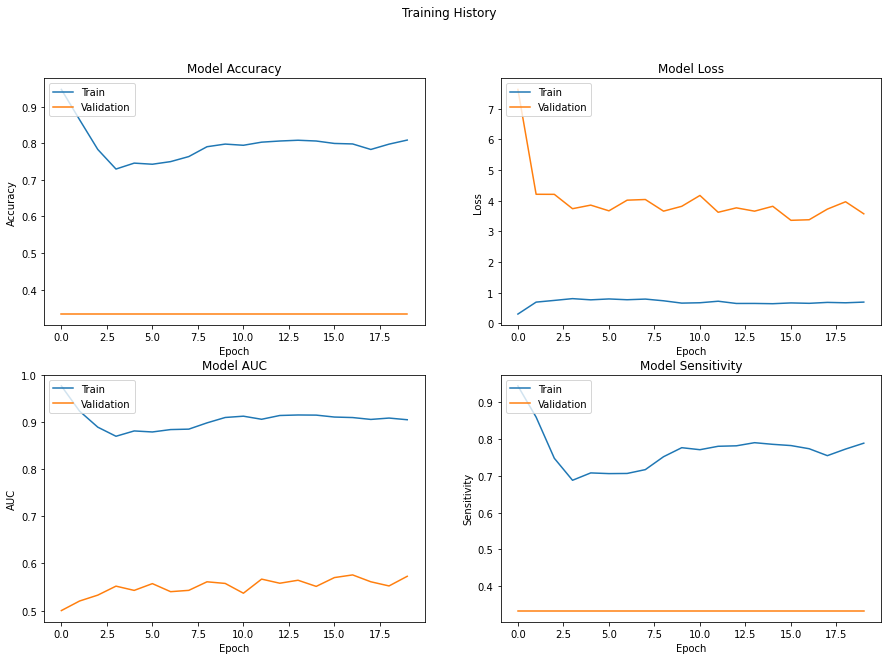

In [ ]:
plot_training_history(efficientnetV2B3_bs32_img128_history)

In [ ]:
experimentsV1_history2 = dict()
# experimentsV1_history['resnet50V2_bs32_img256_history'] = resnet50V2_bs32_img256_history.history
# experimentsV1_history['resnet50V2_bs16_img256_history'] = resnet50V2_bs16_img256_history.history
# experimentsV1_history['resnet50V2_bs16_img128_history'] = resnet50V2_bs16_img128_history.history
# experimentsV1_history['resnet50V2_bs32_img128_history'] = resnet50V2_bs32_img128_history.history
# experimentsV1_history['resnet50V2_bs32_img128_history2'] = resnet50V2_bs32_img128_history2.history
experimentsV1_history2['efficientnetV2B3_bs32_img256_history'] = efficientnetV2B3_bs32_img256_history.history
experimentsV1_history2['efficientnetV2B3_bs16_img256_history'] = efficientnetV2B3_bs16_img256_history.history
experimentsV1_history2['efficientnetV2B3_bs16_img128_history'] = efficientnetV2B3_bs16_img128_history.history
experimentsV1_history2['efficientnetV2B3_bs32_img128_history'] = efficientnetV2B3_bs32_img128_history.history

# Save dictionary to npz file
np.savez(os.path.join(root_dir, 'experimentsV1_history2.npz'), **experimentsV1_history2)

## InceptionResNetV2 Training with CrossEntropy Loss

### InceptionResNetV2 Training - Batch Size 16, Image Size 256

In [ ]:
# Create training, validation and test tensorflow data generators
train_datagen, validation_datagen, test_datagen = create_data_generators(batch_size=16, image_size=256)

Found 14841 images belonging to 3 classes.
Found 1647 images belonging to 3 classes.
Found 4122 images belonging to 3 classes.


In [ ]:
# Create the InceptionResNetV2 base model
inceptionResNetV2_img256_base_model = InceptionResNetV2(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(256, 256, 3),
    classes=num_classes
)

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
# Build the EfficientNetV2B3 model
inceptionResNetV2_bs16_img256 = build_model(
    base_model=inceptionResNetV2_img256_base_model,
    is_trainable=False,
    model_name='inception_resnet_v2',
    image_size=256
)

inceptionResNetV2_bs16_img256 = compile_model(
    inceptionResNetV2_bs16_img256,
    tf.keras.optimizers.Adam(learning_rate=0.0001)
)

========================= MODEL SUMMARY =========================
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_2   (None, 1536)             0   

In [ ]:
inceptionResNetV2_bs16_img256_history = train_model(
    model=inceptionResNetV2_bs16_img256,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='inceptionResNetV2_bs16_img256_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=16
)

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 0.2188 - categorical_accuracy: 0.9843 - auc: 0.9907 - sensitivity: 0.9842
Epoch 1: val_loss improved from inf to 25.69862, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 1166s 1s/step - loss: 0.2188 - categorical_accuracy: 0.9843 - auc: 0.9907 - sensitivity: 0.9842 - val_loss: 25.6986 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 2/20
928/928 [==============================] - ETA: 0s - loss: 0.9083 - categorical_accuracy: 0.9129 - auc: 0.9501 - sensitivity: 0.9126
Epoch 2: val_loss improved from 25.69862 to 9.69065, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 521s 559ms/step - loss: 0.9083 - categorical_accuracy: 0.9129 - auc: 0.9501 - sensitivity: 0.9126 - val_loss: 9.6906 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 3/20
928/928 [==============================] - ETA: 0s - loss: 0.6538 - categorical_accuracy: 0.8702 - auc: 0.9310 - sensitivity: 0.8662
Epoch 3: val_loss improved from 9.69065 to 7.13295, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 532s 570ms/step - loss: 0.6538 - categorical_accuracy: 0.8702 - auc: 0.9310 - sensitivity: 0.8662 - val_loss: 7.1330 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 4/20
928/928 [==============================] - ETA: 0s - loss: 0.5214 - categorical_accuracy: 0.8776 - auc: 0.9378 - sensitivity: 0.8728
Epoch 4: val_loss improved from 7.13295 to 6.96605, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 552s 592ms/step - loss: 0.5214 - categorical_accuracy: 0.8776 - auc: 0.9378 - sensitivity: 0.8728 - val_loss: 6.9660 - val_categorical_accuracy: 0.3333 - val_auc: 0.5001 - val_sensitivity: 0.3333
Epoch 5/20
928/928 [==============================] - ETA: 0s - loss: 0.5680 - categorical_accuracy: 0.8898 - auc: 0.9332 - sensitivity: 0.8868
Epoch 5: val_loss improved from 6.96605 to 5.43280, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 543s 582ms/step - loss: 0.5680 - categorical_accuracy: 0.8898 - auc: 0.9332 - sensitivity: 0.8868 - val_loss: 5.4328 - val_categorical_accuracy: 0.3333 - val_auc: 0.4988 - val_sensitivity: 0.3333
Epoch 6/20
928/928 [==============================] - ETA: 0s - loss: 0.6237 - categorical_accuracy: 0.8408 - auc: 0.9174 - sensitivity: 0.8305
Epoch 6: val_loss improved from 5.43280 to 3.60624, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 542s 581ms/step - loss: 0.6237 - categorical_accuracy: 0.8408 - auc: 0.9174 - sensitivity: 0.8305 - val_loss: 3.6062 - val_categorical_accuracy: 0.3333 - val_auc: 0.4950 - val_sensitivity: 0.3333
Epoch 7/20
928/928 [==============================] - ETA: 0s - loss: 0.6034 - categorical_accuracy: 0.7984 - auc: 0.9225 - sensitivity: 0.7365
Epoch 7: val_loss did not improve from 3.60624
928/928 [==============================] - 443s 475ms/step - loss: 0.6034 - categorical_accuracy: 0.7984 - auc: 0.9225 - sensitivity: 0.7365 - val_loss: 3.7780 - val_categorical_accuracy: 0.3333 - val_auc: 0.4914 - val_sensitivity: 0.3333
Epoch 8/20
928/928 [==============================] - ETA: 0s - loss: 0.5823 - categorical_accuracy: 0.7276 - auc: 0.9148 - sensitivity: 0.7029
Epoch 8: val_loss improved from 3.60624 to 3.59738, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 536s 574ms/step - loss: 0.5823 - categorical_accuracy: 0.7276 - auc: 0.9148 - sensitivity: 0.7029 - val_loss: 3.5974 - val_categorical_accuracy: 0.3333 - val_auc: 0.5023 - val_sensitivity: 0.3333
Epoch 9/20
928/928 [==============================] - ETA: 0s - loss: 0.5607 - categorical_accuracy: 0.8107 - auc: 0.9283 - sensitivity: 0.7961
Epoch 9: val_loss did not improve from 3.59738
928/928 [==============================] - 445s 477ms/step - loss: 0.5607 - categorical_accuracy: 0.8107 - auc: 0.9283 - sensitivity: 0.7961 - val_loss: 4.7529 - val_categorical_accuracy: 0.3333 - val_auc: 0.4962 - val_sensitivity: 0.3333
Epoch 10/20
928/928 [==============================] - ETA: 0s - loss: 0.6199 - categorical_accuracy: 0.8557 - auc: 0.9103 - sensitivity: 0.8487
Epoch 10: val_loss improved from 3.59738 to 3.51513, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 551s 591ms/step - loss: 0.6199 - categorical_accuracy: 0.8557 - auc: 0.9103 - sensitivity: 0.8487 - val_loss: 3.5151 - val_categorical_accuracy: 0.3333 - val_auc: 0.4950 - val_sensitivity: 0.3333
Epoch 11/20
928/928 [==============================] - ETA: 0s - loss: 0.4411 - categorical_accuracy: 0.8679 - auc: 0.9416 - sensitivity: 0.8625
Epoch 11: val_loss did not improve from 3.51513
928/928 [==============================] - 473s 506ms/step - loss: 0.4411 - categorical_accuracy: 0.8679 - auc: 0.9416 - sensitivity: 0.8625 - val_loss: 5.0634 - val_categorical_accuracy: 0.3333 - val_auc: 0.4982 - val_sensitivity: 0.3333
Epoch 12/20
928/928 [==============================] - ETA: 0s - loss: 0.5249 - categorical_accuracy: 0.8415 - auc: 0.9205 - sensitivity: 0.8320
Epoch 12: val_loss improved from 3.51513 to 3.14414, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 552s 591ms/step - loss: 0.5249 - categorical_accuracy: 0.8415 - auc: 0.9205 - sensitivity: 0.8320 - val_loss: 3.1441 - val_categorical_accuracy: 0.3333 - val_auc: 0.5143 - val_sensitivity: 0.3333
Epoch 13/20
928/928 [==============================] - ETA: 0s - loss: 0.4423 - categorical_accuracy: 0.8707 - auc: 0.9435 - sensitivity: 0.8648
Epoch 13: val_loss did not improve from 3.14414
928/928 [==============================] - 435s 466ms/step - loss: 0.4423 - categorical_accuracy: 0.8707 - auc: 0.9435 - sensitivity: 0.8648 - val_loss: 3.3894 - val_categorical_accuracy: 0.3333 - val_auc: 0.5180 - val_sensitivity: 0.3333
Epoch 14/20
928/928 [==============================] - ETA: 0s - loss: 0.4639 - categorical_accuracy: 0.8615 - auc: 0.9310 - sensitivity: 0.8559
Epoch 14: val_loss improved from 3.14414 to 2.66806, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 544s 583ms/step - loss: 0.4639 - categorical_accuracy: 0.8615 - auc: 0.9310 - sensitivity: 0.8559 - val_loss: 2.6681 - val_categorical_accuracy: 0.3333 - val_auc: 0.5310 - val_sensitivity: 0.3333
Epoch 15/20
928/928 [==============================] - ETA: 0s - loss: 0.4909 - categorical_accuracy: 0.8561 - auc: 0.9298 - sensitivity: 0.8486
Epoch 15: val_loss did not improve from 2.66806
928/928 [==============================] - 436s 466ms/step - loss: 0.4909 - categorical_accuracy: 0.8561 - auc: 0.9298 - sensitivity: 0.8486 - val_loss: 2.6829 - val_categorical_accuracy: 0.3333 - val_auc: 0.5225 - val_sensitivity: 0.3333
Epoch 16/20
928/928 [==============================] - ETA: 0s - loss: 0.5539 - categorical_accuracy: 0.8477 - auc: 0.9186 - sensitivity: 0.8373
Epoch 16: val_loss improved from 2.66806 to 2.40437, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img256_trainableFalse/checkpoint


928/928 [==============================] - 530s 568ms/step - loss: 0.5539 - categorical_accuracy: 0.8477 - auc: 0.9186 - sensitivity: 0.8373 - val_loss: 2.4044 - val_categorical_accuracy: 0.3333 - val_auc: 0.5306 - val_sensitivity: 0.3333
Epoch 17/20
928/928 [==============================] - ETA: 0s - loss: 0.5977 - categorical_accuracy: 0.8139 - auc: 0.9117 - sensitivity: 0.7885
Epoch 17: val_loss did not improve from 2.40437
928/928 [==============================] - 436s 467ms/step - loss: 0.5977 - categorical_accuracy: 0.8139 - auc: 0.9117 - sensitivity: 0.7885 - val_loss: 3.2241 - val_categorical_accuracy: 0.3333 - val_auc: 0.5017 - val_sensitivity: 0.3333
Epoch 18/20
928/928 [==============================] - ETA: 0s - loss: 0.5084 - categorical_accuracy: 0.8271 - auc: 0.9296 - sensitivity: 0.8105
Epoch 18: val_loss did not improve from 2.40437
928/928 [==============================] - 438s 469ms/step - loss: 0.5084 - categorical_accuracy: 0.8271 - auc: 0.9296 - sensitivity: 0.

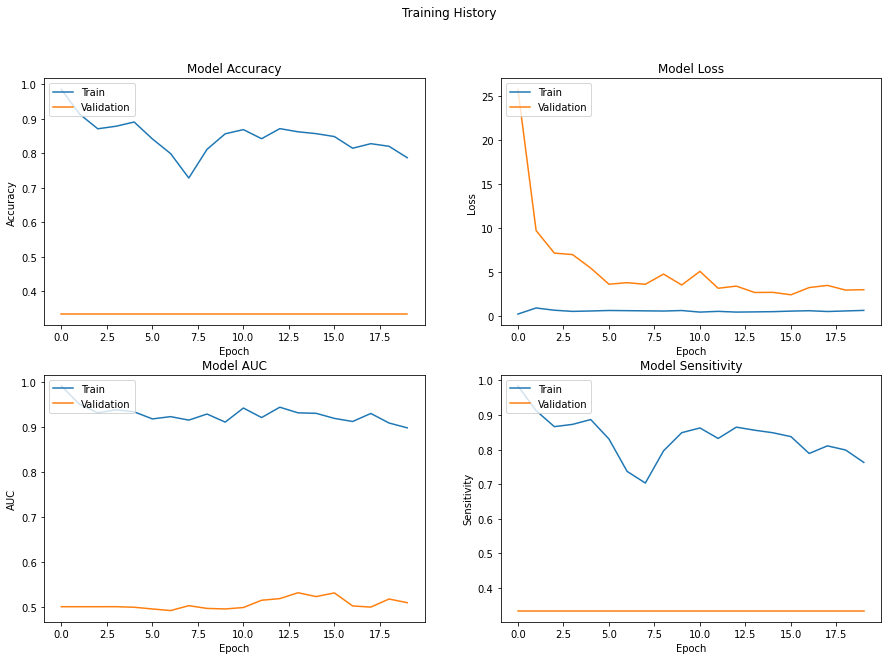

In [ ]:
plot_training_history(inceptionResNetV2_bs16_img256_history)

In [ ]:
experimentsV1_history3 = dict()
# experimentsV1_history['resnet50V2_bs32_img256_history'] = resnet50V2_bs32_img256_history.history
# experimentsV1_history['resnet50V2_bs16_img256_history'] = resnet50V2_bs16_img256_history.history
# experimentsV1_history['resnet50V2_bs16_img128_history'] = resnet50V2_bs16_img128_history.history
# experimentsV1_history['resnet50V2_bs32_img128_history'] = resnet50V2_bs32_img128_history.history
# experimentsV1_history['resnet50V2_bs32_img128_history2'] = resnet50V2_bs32_img128_history2.history
# experimentsV1_history3['efficientnetV2B3_bs32_img256_history'] = efficientnetV2B3_bs32_img256_history.history
# experimentsV1_history3['efficientnetV2B3_bs16_img256_history'] = efficientnetV2B3_bs16_img256_history.history
experimentsV1_history3['inceptionResNetV2_bs16_img256_history'] = inceptionResNetV2_bs16_img256_history.history

# Save dictionary to npz file
np.savez(os.path.join(root_dir, 'experimentsV1_history3.npz'), **experimentsV1_history3)

### InceptionResNetV2 Training - Batch Size 32, Image Size 256

In [ ]:
# Create training, validation and test tensorflow data generators
train_datagen, validation_datagen, test_datagen = create_data_generators(batch_size=32, image_size=256)

Found 14841 images belonging to 3 classes.
Found 1647 images belonging to 3 classes.
Found 4122 images belonging to 3 classes.


In [ ]:
# Build the EfficientNetV2B3 model
inceptionResNetV2_bs32_img256 = build_model(
    base_model=inceptionResNetV2_img256_base_model,
    is_trainable=False,
    model_name='inception_resnet_v2',
    image_size=256
)

inceptionResNetV2_bs32_img256 = compile_model(
    inceptionResNetV2_bs32_img256,
    tf.keras.optimizers.Adam(learning_rate=0.0001)
)

========================= MODEL SUMMARY =========================
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1536)             0   

In [ ]:
inceptionResNetV2_bs32_img256_history = train_model(
    model=inceptionResNetV2_bs32_img256,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='inceptionResNetV2_bs32_img256_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=32
)

Epoch 1/20
464/464 [==============================] - ETA: 0s - loss: 0.4482 - categorical_accuracy: 0.9688 - auc: 0.9815 - sensitivity: 0.9687
Epoch 1: val_loss improved from inf to 23.47334, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs32_img256_trainableFalse/checkpoint


464/464 [==============================] - 575s 1s/step - loss: 0.4482 - categorical_accuracy: 0.9688 - auc: 0.9815 - sensitivity: 0.9687 - val_loss: 23.4733 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 2/20
464/464 [==============================] - ETA: 0s - loss: 1.6660 - categorical_accuracy: 0.8543 - auc: 0.9147 - sensitivity: 0.8528
Epoch 2: val_loss improved from 23.47334 to 8.39069, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs32_img256_trainableFalse/checkpoint


464/464 [==============================] - 532s 1s/step - loss: 1.6660 - categorical_accuracy: 0.8543 - auc: 0.9147 - sensitivity: 0.8528 - val_loss: 8.3907 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 3/20
464/464 [==============================] - ETA: 0s - loss: 1.0242 - categorical_accuracy: 0.8295 - auc: 0.8883 - sensitivity: 0.8270
Epoch 3: val_loss improved from 8.39069 to 4.94915, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs32_img256_trainableFalse/checkpoint


464/464 [==============================] - 537s 1s/step - loss: 1.0242 - categorical_accuracy: 0.8295 - auc: 0.8883 - sensitivity: 0.8270 - val_loss: 4.9492 - val_categorical_accuracy: 0.3333 - val_auc: 0.4967 - val_sensitivity: 0.3333
Epoch 4/20
464/464 [==============================] - ETA: 0s - loss: 0.7016 - categorical_accuracy: 0.8037 - auc: 0.8855 - sensitivity: 0.7898
Epoch 4: val_loss improved from 4.94915 to 4.86864, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs32_img256_trainableFalse/checkpoint


464/464 [==============================] - 537s 1s/step - loss: 0.7016 - categorical_accuracy: 0.8037 - auc: 0.8855 - sensitivity: 0.7898 - val_loss: 4.8686 - val_categorical_accuracy: 0.3333 - val_auc: 0.4962 - val_sensitivity: 0.3333
Epoch 5/20
464/464 [==============================] - ETA: 0s - loss: 0.6440 - categorical_accuracy: 0.8121 - auc: 0.9073 - sensitivity: 0.8073
Epoch 5: val_loss improved from 4.86864 to 3.68341, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs32_img256_trainableFalse/checkpoint


464/464 [==============================] - 544s 1s/step - loss: 0.6440 - categorical_accuracy: 0.8121 - auc: 0.9073 - sensitivity: 0.8073 - val_loss: 3.6834 - val_categorical_accuracy: 0.3333 - val_auc: 0.4998 - val_sensitivity: 0.3333
Epoch 6/20
464/464 [==============================] - ETA: 0s - loss: 0.7261 - categorical_accuracy: 0.7860 - auc: 0.8834 - sensitivity: 0.7659
Epoch 6: val_loss improved from 3.68341 to 3.63341, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs32_img256_trainableFalse/checkpoint


464/464 [==============================] - 579s 1s/step - loss: 0.7261 - categorical_accuracy: 0.7860 - auc: 0.8834 - sensitivity: 0.7659 - val_loss: 3.6334 - val_categorical_accuracy: 0.3333 - val_auc: 0.4961 - val_sensitivity: 0.3333
Epoch 7/20
464/464 [==============================] - ETA: 0s - loss: 0.7336 - categorical_accuracy: 0.7634 - auc: 0.8887 - sensitivity: 0.7478
Epoch 7: val_loss did not improve from 3.63341
464/464 [==============================] - 451s 963ms/step - loss: 0.7336 - categorical_accuracy: 0.7634 - auc: 0.8887 - sensitivity: 0.7478 - val_loss: 4.1927 - val_categorical_accuracy: 0.3333 - val_auc: 0.4982 - val_sensitivity: 0.3333
Epoch 8/20
464/464 [==============================] - ETA: 0s - loss: 0.7050 - categorical_accuracy: 0.8095 - auc: 0.8944 - sensitivity: 0.7976
Epoch 8: val_loss improved from 3.63341 to 3.32928, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs32_img256_trainableFalse/checkpoint


464/464 [==============================] - 570s 1s/step - loss: 0.7050 - categorical_accuracy: 0.8095 - auc: 0.8944 - sensitivity: 0.7976 - val_loss: 3.3293 - val_categorical_accuracy: 0.3333 - val_auc: 0.5089 - val_sensitivity: 0.3333
Epoch 9/20
464/464 [==============================] - ETA: 0s - loss: 0.7150 - categorical_accuracy: 0.7856 - auc: 0.8779 - sensitivity: 0.7679
Epoch 9: val_loss did not improve from 3.32928
464/464 [==============================] - 468s 999ms/step - loss: 0.7150 - categorical_accuracy: 0.7856 - auc: 0.8779 - sensitivity: 0.7679 - val_loss: 4.2239 - val_categorical_accuracy: 0.3333 - val_auc: 0.4999 - val_sensitivity: 0.3333
Epoch 10/20
464/464 [==============================] - ETA: 0s - loss: 0.8816 - categorical_accuracy: 0.7538 - auc: 0.8532 - sensitivity: 0.7272
Epoch 10: val_loss did not improve from 3.32928
464/464 [==============================] - 459s 980ms/step - loss: 0.8816 - categorical_accuracy: 0.7538 - auc: 0.8532 - sensitivity: 0.7272 

464/464 [==============================] - 565s 1s/step - loss: 0.8375 - categorical_accuracy: 0.7933 - auc: 0.8655 - sensitivity: 0.7801 - val_loss: 2.1750 - val_categorical_accuracy: 0.3333 - val_auc: 0.5314 - val_sensitivity: 0.3333
Epoch 12/20
464/464 [==============================] - ETA: 0s - loss: 0.8157 - categorical_accuracy: 0.7359 - auc: 0.8502 - sensitivity: 0.7006
Epoch 12: val_loss improved from 2.17498 to 1.81211, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs32_img256_trainableFalse/checkpoint


464/464 [==============================] - 551s 1s/step - loss: 0.8157 - categorical_accuracy: 0.7359 - auc: 0.8502 - sensitivity: 0.7006 - val_loss: 1.8121 - val_categorical_accuracy: 0.3333 - val_auc: 0.5486 - val_sensitivity: 0.3333
Epoch 13/20
464/464 [==============================] - ETA: 0s - loss: 0.8566 - categorical_accuracy: 0.7154 - auc: 0.8455 - sensitivity: 0.6666
Epoch 13: val_loss did not improve from 1.81211
464/464 [==============================] - 463s 989ms/step - loss: 0.8566 - categorical_accuracy: 0.7154 - auc: 0.8455 - sensitivity: 0.6666 - val_loss: 2.1865 - val_categorical_accuracy: 0.3333 - val_auc: 0.5481 - val_sensitivity: 0.3333
Epoch 14/20
333/464 [====================>.........] - ETA: 1:50 - loss: 1.1525 - categorical_accuracy: 0.6465 - auc: 0.7916 - sensitivity: 0.5795

UnknownError: ignored

In [ ]:
inceptionResNetV2_bs32_img256 = load_model(outputs_dir, 'inceptionResNetV2_bs32_img256_trainableFalse')

In [ ]:
inceptionResNetV2_bs32_img256_history = train_model(
    model=inceptionResNetV2_bs32_img256,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='inceptionResNetV2_bs32_img256_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=32,
    initial_epoch=13,
    initial_value_threshold=1.81211
)

Epoch 14/20
464/464 [==============================] - ETA: 0s - loss: 0.7640 - categorical_accuracy: 0.8063 - auc: 0.9258 - sensitivity: 0.8031
Epoch 14: val_loss did not improve from 1.81211
464/464 [==============================] - 436s 910ms/step - loss: 0.7640 - categorical_accuracy: 0.8063 - auc: 0.9258 - sensitivity: 0.8031 - val_loss: 7.7864 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 15/20
464/464 [==============================] - ETA: 0s - loss: 0.7655 - categorical_accuracy: 0.8324 - auc: 0.8942 - sensitivity: 0.8275
Epoch 15: val_loss did not improve from 1.81211
464/464 [==============================] - 429s 919ms/step - loss: 0.7655 - categorical_accuracy: 0.8324 - auc: 0.8942 - sensitivity: 0.8275 - val_loss: 3.8045 - val_categorical_accuracy: 0.3333 - val_auc: 0.5100 - val_sensitivity: 0.3333
Epoch 16/20
464/464 [==============================] - ETA: 0s - loss: 0.5865 - categorical_accuracy: 0.8439 - auc: 0.9238 - sensitivity

In [ ]:
inceptionResNetV2_bs32_img256_full_history = load_training_history(
    outputs_dir, 'inceptionResNetV2_bs32_img256_trainableFalse'
)

<ipython-input-21-e80cd3ed86e9>:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  history.history = history


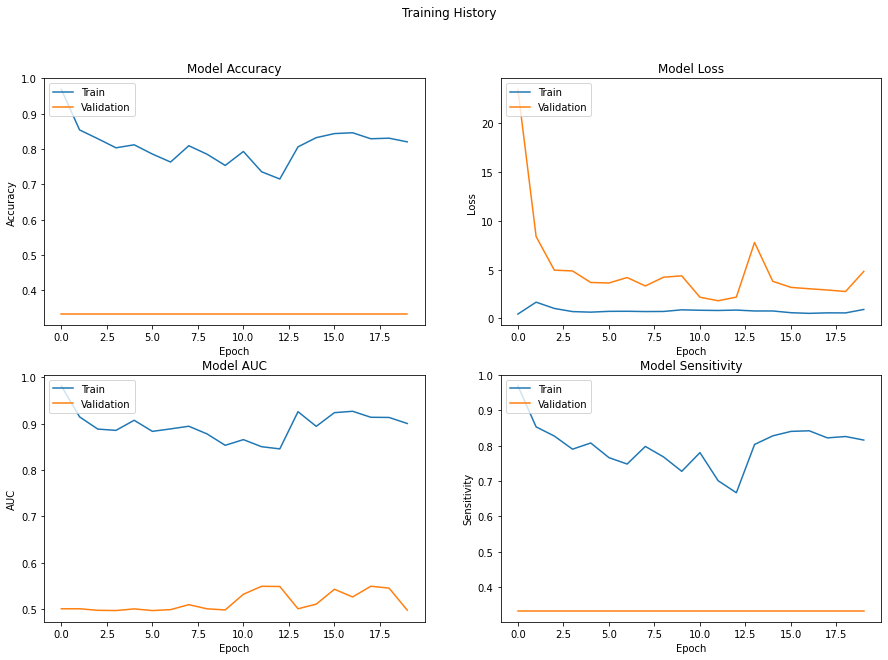

In [ ]:
plot_training_history(inceptionResNetV2_bs32_img256_full_history, from_csv=True)

### InceptionResNetV2 Training - Batch Size 16, Image Size 128

In [ ]:
# Create training, validation and test tensorflow data generators
train_datagen, validation_datagen, test_datagen = create_data_generators(batch_size=16, image_size=128)

Found 14841 images belonging to 3 classes.
Found 1647 images belonging to 3 classes.
Found 4122 images belonging to 3 classes.


In [ ]:
# Create the InceptionResNetV2 base model
inceptionResNetV2_img128_base_model = InceptionResNetV2(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(128, 128, 3),
    classes=num_classes
)

In [ ]:
# Build the EfficientNetV2B3 model
inceptionResNetV2_bs16_img128 = build_model(
    base_model=inceptionResNetV2_img128_base_model,
    is_trainable=False,
    model_name='inception_resnet_v2',
    image_size=128
)

inceptionResNetV2_bs16_img128 = compile_model(
    inceptionResNetV2_bs16_img128,
    tf.keras.optimizers.Adam(learning_rate=0.0001)
)

========================= MODEL SUMMARY =========================
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0     

In [ ]:
inceptionResNetV2_bs16_img128_history = train_model(
    model=inceptionResNetV2_bs16_img128,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='inceptionResNetV2_bs16_img128_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=16
)

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 0.4187 - categorical_accuracy: 0.9838 - auc: 0.9905 - sensitivity: 0.9835
Epoch 1: val_loss improved from inf to 49.46090, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 329s 339ms/step - loss: 0.4187 - categorical_accuracy: 0.9838 - auc: 0.9905 - sensitivity: 0.9835 - val_loss: 49.4609 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 2/20
928/928 [==============================] - ETA: 0s - loss: 1.4077 - categorical_accuracy: 0.9304 - auc: 0.9611 - sensitivity: 0.9303
Epoch 2: val_loss improved from 49.46090 to 8.31305, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 326s 349ms/step - loss: 1.4077 - categorical_accuracy: 0.9304 - auc: 0.9611 - sensitivity: 0.9303 - val_loss: 8.3130 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 3/20
928/928 [==============================] - ETA: 0s - loss: 0.7031 - categorical_accuracy: 0.8995 - auc: 0.9487 - sensitivity: 0.8983
Epoch 3: val_loss did not improve from 8.31305
928/928 [==============================] - 210s 222ms/step - loss: 0.7031 - categorical_accuracy: 0.8995 - auc: 0.9487 - sensitivity: 0.8983 - val_loss: 8.5030 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000 - val_sensitivity: 0.3333
Epoch 4/20
928/928 [==============================] - ETA: 0s - loss: 0.4670 - categorical_accuracy: 0.9165 - auc: 0.9554 - sensitivity: 0.9102
Epoch 4: val_loss improved from 8.31305 to 4.60470, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 320s 342ms/step - loss: 0.4670 - categorical_accuracy: 0.9165 - auc: 0.9554 - sensitivity: 0.9102 - val_loss: 4.6047 - val_categorical_accuracy: 0.3333 - val_auc: 0.5062 - val_sensitivity: 0.3333
Epoch 5/20
928/928 [==============================] - ETA: 0s - loss: 0.3981 - categorical_accuracy: 0.9057 - auc: 0.9664 - sensitivity: 0.9042
Epoch 5: val_loss did not improve from 4.60470
928/928 [==============================] - 211s 225ms/step - loss: 0.3981 - categorical_accuracy: 0.9057 - auc: 0.9664 - sensitivity: 0.9042 - val_loss: 6.6256 - val_categorical_accuracy: 0.3333 - val_auc: 0.4994 - val_sensitivity: 0.3333
Epoch 6/20
928/928 [==============================] - ETA: 0s - loss: 0.4908 - categorical_accuracy: 0.9035 - auc: 0.9553 - sensitivity: 0.9015
Epoch 6: val_loss improved from 4.60470 to 3.52859, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/inceptionResNetV2_bs16_img128_trainableFalse/checkpoint


928/928 [==============================] - 330s 353ms/step - loss: 0.4908 - categorical_accuracy: 0.9035 - auc: 0.9553 - sensitivity: 0.9015 - val_loss: 3.5286 - val_categorical_accuracy: 0.3333 - val_auc: 0.5239 - val_sensitivity: 0.3333
Epoch 7/20
928/928 [==============================] - ETA: 0s - loss: 0.4362 - categorical_accuracy: 0.9157 - auc: 0.9679 - sensitivity: 0.9018
Epoch 7: val_loss did not improve from 3.52859
928/928 [==============================] - 209s 222ms/step - loss: 0.4362 - categorical_accuracy: 0.9157 - auc: 0.9679 - sensitivity: 0.9018 - val_loss: 5.4006 - val_categorical_accuracy: 0.3333 - val_auc: 0.5034 - val_sensitivity: 0.3333
Epoch 8/20
928/928 [==============================] - ETA: 0s - loss: 0.4778 - categorical_accuracy: 0.9303 - auc: 0.9647 - sensitivity: 0.9266
Epoch 8: val_loss did not improve from 3.52859
928/928 [==============================] - 208s 222ms/step - loss: 0.4778 - categorical_accuracy: 0.9303 - auc: 0.9647 - sensitivity: 0.9266

928/928 [==============================] - 322s 345ms/step - loss: 0.6135 - categorical_accuracy: 0.8391 - auc: 0.9168 - sensitivity: 0.8264 - val_loss: 3.4313 - val_categorical_accuracy: 0.3333 - val_auc: 0.5260 - val_sensitivity: 0.3333
Epoch 20/20
928/928 [==============================] - ETA: 0s - loss: 0.5372 - categorical_accuracy: 0.8324 - auc: 0.9301 - sensitivity: 0.8036
Epoch 20: val_loss did not improve from 3.43133
928/928 [==============================] - 193s 205ms/step - loss: 0.5372 - categorical_accuracy: 0.8324 - auc: 0.9301 - sensitivity: 0.8036 - val_loss: 5.3447 - val_categorical_accuracy: 0.3333 - val_auc: 0.5025 - val_sensitivity: 0.3333


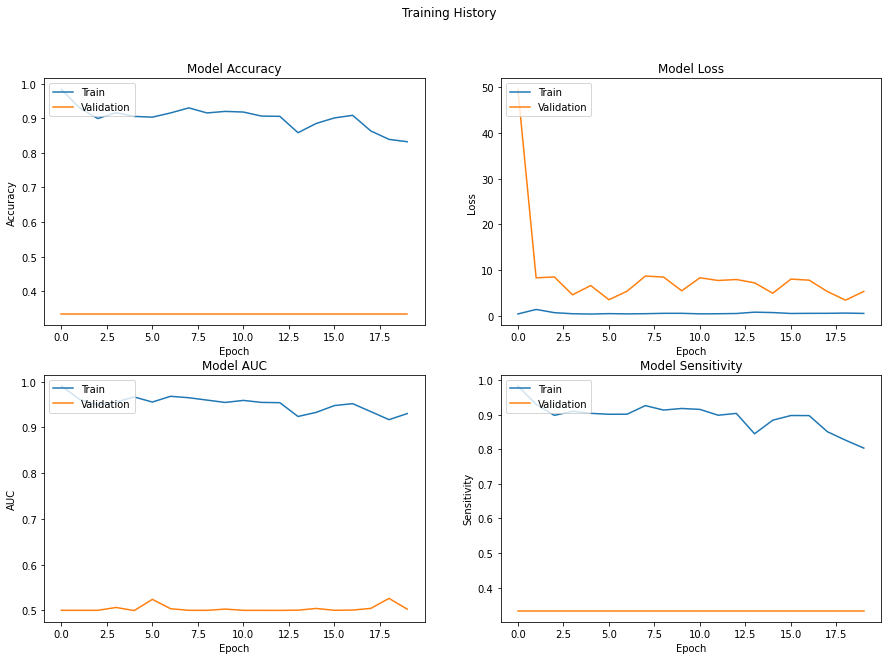

In [ ]:
plot_training_history(inceptionResNetV2_bs16_img128_history)

## EfficientNetB3 Training with Focal Loss

### EfficientNetB3 Training - Batch Size 16, Image Size 256

In [ ]:
# Create training, validation and test tensorflow data generators
train_datagen, validation_datagen, test_datagen = create_data_generators(batch_size=16, image_size=256)

Found 14841 images belonging to 3 classes.
Found 1647 images belonging to 3 classes.
Found 4122 images belonging to 3 classes.


In [ ]:
# Create the EfficientNetV2B3 base model
efficientnetV2B3_img256_base_model = EfficientNetV2B3(
    weights='imagenet',     # Load weights pre-trained on ImageNet
    include_top=False,      # Do not include the ImageNet classifier at the top
    input_shape=(256, 256, 3),
    classes=num_classes,
    include_preprocessing=True
)

In [ ]:
# Build the EfficientNetV2B3 model
efficientnetV2B3_bs16_img256_focalLoss = build_model(
    base_model=efficientnetV2B3_img256_base_model,
    is_trainable=False,
    model_name='efficientnet',
    image_size=256
)

efficientnetV2B3_bs16_img256_focalLoss = compile_model(
    efficientnetV2B3_bs16_img256_focalLoss,
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)]
)

========================= MODEL SUMMARY =========================
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, 8, 8, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d_4   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 512)               786944    
                                                                 
 dense_9 (Dense)             (None, 3)                 1539      
                                                           

In [ ]:
efficientnetV2B3_bs16_img256_focalLoss_history = train_model(
    model=efficientnetV2B3_bs16_img256_focalLoss,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='efficientnetV2B3_bs16_img256_focalLoss_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=16
)

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 0.0225 - categorical_accuracy: 0.9805 - auc: 0.9930 - sensitivity: 0.9792
Epoch 1: val_loss improved from inf to 1.91330, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs16_img256_focalLoss_trainableFalse/checkpoint


928/928 [==============================] - 461s 468ms/step - loss: 0.0225 - categorical_accuracy: 0.9805 - auc: 0.9930 - sensitivity: 0.9792 - val_loss: 1.9133 - val_categorical_accuracy: 0.3333 - val_auc: 0.5001 - val_sensitivity: 0.3333
Epoch 2/20
928/928 [==============================] - ETA: 0s - loss: 0.0573 - categorical_accuracy: 0.9387 - auc: 0.9702 - sensitivity: 0.9334
Epoch 2: val_loss improved from 1.91330 to 0.72900, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs16_img256_focalLoss_trainableFalse/checkpoint


928/928 [==============================] - 424s 454ms/step - loss: 0.0573 - categorical_accuracy: 0.9387 - auc: 0.9702 - sensitivity: 0.9334 - val_loss: 0.7290 - val_categorical_accuracy: 0.3333 - val_auc: 0.5455 - val_sensitivity: 0.3333
Epoch 3/20
928/928 [==============================] - ETA: 0s - loss: 0.0397 - categorical_accuracy: 0.9224 - auc: 0.9743 - sensitivity: 0.9094
Epoch 3: val_loss improved from 0.72900 to 0.52633, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs16_img256_focalLoss_trainableFalse/checkpoint


928/928 [==============================] - 404s 432ms/step - loss: 0.0397 - categorical_accuracy: 0.9224 - auc: 0.9743 - sensitivity: 0.9094 - val_loss: 0.5263 - val_categorical_accuracy: 0.3333 - val_auc: 0.5788 - val_sensitivity: 0.3333
Epoch 4/20
928/928 [==============================] - ETA: 0s - loss: 0.0332 - categorical_accuracy: 0.9189 - auc: 0.9780 - sensitivity: 0.8985
Epoch 4: val_loss improved from 0.52633 to 0.45786, saving model to /content/drive/MyDrive/Colab Notebooks/initial_experiments/efficientnetV2B3_bs16_img256_focalLoss_trainableFalse/checkpoint


928/928 [==============================] - 371s 396ms/step - loss: 0.0332 - categorical_accuracy: 0.9189 - auc: 0.9780 - sensitivity: 0.8985 - val_loss: 0.4579 - val_categorical_accuracy: 0.3333 - val_auc: 0.5771 - val_sensitivity: 0.3333
Epoch 5/20
889/928 [===========================>..] - ETA: 10s - loss: 0.0339 - categorical_accuracy: 0.9178 - auc: 0.9796 - sensitivity: 0.9053

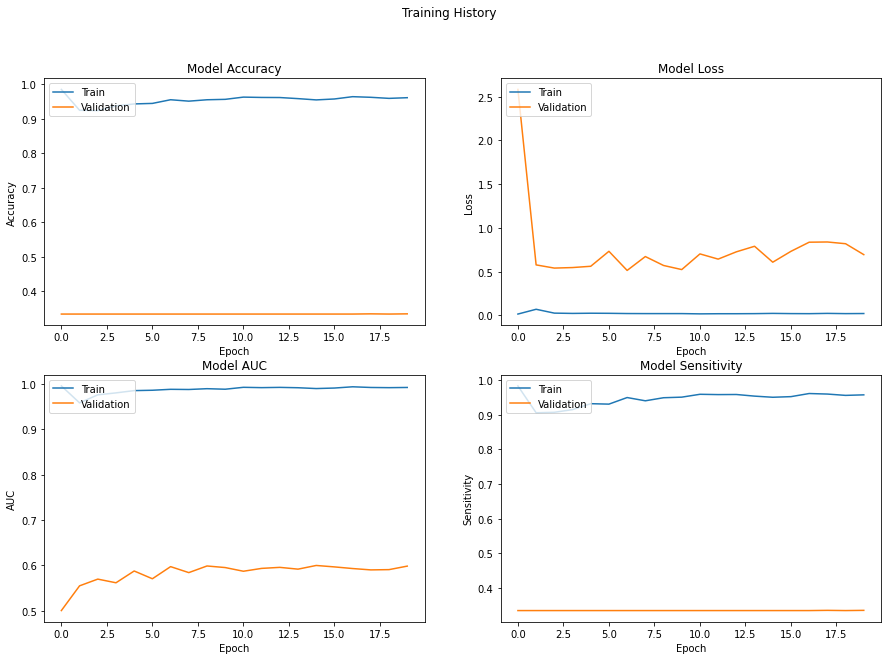

In [ ]:
plot_training_history(efficientnetV2B3_bs16_img256_focalLoss_history)

In [ ]:
efficientnetV2B3_bs16_img256_focalLoss_history2 = train_model(
    model=efficientnetV2B3_bs16_img256_focalLoss,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='efficientnetV2B3_bs16_img256_focalLoss_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=16,
    initial_epoch=17,
    initial_value_threshold=0.51410
)

Epoch 18/20
928/928 [==============================] - ETA: 0s - loss: 0.0234 - categorical_accuracy: 0.9602 - auc: 0.9919 - sensitivity: 0.9576
Epoch 18: val_loss did not improve from 0.51410
928/928 [==============================] - 267s 284ms/step - loss: 0.0234 - categorical_accuracy: 0.9602 - auc: 0.9919 - sensitivity: 0.9576 - val_loss: 0.5646 - val_categorical_accuracy: 0.3352 - val_auc: 0.5958 - val_sensitivity: 0.3327
Epoch 19/20
928/928 [==============================] - ETA: 0s - loss: 0.0234 - categorical_accuracy: 0.9545 - auc: 0.9902 - sensitivity: 0.9508
Epoch 19: val_loss did not improve from 0.51410
928/928 [==============================] - 264s 282ms/step - loss: 0.0234 - categorical_accuracy: 0.9545 - auc: 0.9902 - sensitivity: 0.9508 - val_loss: 0.7738 - val_categorical_accuracy: 0.3333 - val_auc: 0.5788 - val_sensitivity: 0.3333
Epoch 20/20
928/928 [==============================] - ETA: 0s - loss: 0.0246 - categorical_accuracy: 0.9507 - auc: 0.9882 - sensitivity

In [ ]:
efficientnetV2B3_bs16_img256_focalLoss_history = train_model(
    model=efficientnetV2B3_bs16_img256_focalLoss,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    model_dir_name='efficientnetV2B3_bs16_img256_catFocalLoss_trainableFalse',
    outputs_dir=os.path.join(root_dir, "initial_experiments"),
    epochs=20,
    batch_size=16
)

Epoch 1/20
669/928 [====================>.........] - ETA: 1:21 - loss: 0.0299 - categorical_accuracy: 0.9780 - auc: 0.9901 - sensitivity: 0.9766

Process Keras_worker_ForkPoolWorker-825:
Process Keras_worker_ForkPoolWorker-827:
Process Keras_worker_ForkPoolWorker-826:
Process Keras_worker_ForkPoolWorker-828:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    r

KeyboardInterrupt: ignored

# Miscellaneous (to clean up)

In [ ]:
out_dir = os.path.join(outputs_dir, 'vggnet16_trainableFalse')
model_dir = os.path.join(out_dir, 'vggnet16_trainableFalse_model')
vggnet16_model = load_model(model_dir)

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB4

def build_model(hp):
    base_model = EfficientNetB4(
        weights='imagenet',     # Load weights pre-trained on ImageNet
        include_top=False,      # Do not include the ImageNet classifier at the top
        input_shape=(128, 128, 3),
    )
    # # Create the VGG16 base model
    # base_model = VGG16(
    #     weights='imagenet',     # Load weights pre-trained on ImageNet
    #     include_top=False,      # Do not include the ImageNet classifier at the top
    #     input_shape=(image_size, image_size, 3),
    # )

    for layer in base_model.layers:
        layer.trainable = False
        
    inputs = tf.keras.Input(shape=(128, 128, 3))

    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base_model(x, training=False)

    if hp.Choice('pooling_', ['flatten', 'avg', 'max']) == 'flatten':
        x = layers.Reshape((4 * 4, 1792))(x)
        x = layers.Flatten()(x)
    elif hp.Choice('pooling_', ['avg', 'max', 'flatten']) == 'avg':
        x = layers.GlobalAveragePooling2D()(x)
    elif hp.Choice('pooling_', ['avg', 'max', 'flatten']) == 'max':
        x = layers.GlobalMaxPooling2D()(x)
    
    
    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 5
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(hp.Int("num_layers", 1, 5, default=1)):
        x = layers.Dense(
             units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32, default=256), 
             activation=hp.Choice(f"activation_{i}", ["relu", "tanh"], default="relu")
        )(x)
        
        # Tune dropout layer with values from 0 - 0.5.
        x = layers.Dropout(hp.Float(f"dropout_{i}", 0, 0.5, step=0.1, default=0))(x)

    # Add output layer.
    prediction = layers.Dense(3, activation='softmax')(x)

    # create a model object
    model = tf.keras.Model(inputs=inputs, outputs=prediction)

    hp_optimizer = hp.Choice('optimizer', values=['adam', 'adamw', 'rmsprop', 'sgd'])

    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate_adam = hp.Float("learning_rate_adam", min_value=1e-6, max_value=1e-1, sampling="log", default=0.00146)
    hp_weight_decay_adam = hp.Float("weight_decay_adam", min_value=1e-6, max_value=1e-1, sampling="log", default=0)
    
    hp_learning_rate_rmsprop = hp.Float("learning_rate_rmsprop", min_value=1e-6, max_value=1e-1, sampling="log", default=0.00146)
    hp_momentum_rmsprop = hp.Float("momentum_rmsprop", min_value=0, max_value=1, step=0.1, default=0)
    hp_weight_decay_rmsprop = hp.Float("weight_decay_rmsprop", min_value=1e-6, max_value=1e-1, sampling="log", default=0)

    hp_learning_rate_sgd = hp.Float("learning_rate_sgd", min_value=1e-6, max_value=1e-1, sampling="log", default=0.01)
    hp_momentum_sgd = hp.Float("momentum_sgd", min_value=0, max_value=1, step=0.1, default=0.9)
    hp_weight_decay_sgd = hp.Float("weight_decay_sgd", min_value=1e-6, max_value=1e-1, sampling="log", default=1e-5)

    hp_learning_rate_adamw = hp.Float("learning_rate_adamw", min_value=1e-6, max_value=1e-1, sampling="log", default=3e-3)
    hp_weight_decay_adamw = hp.Float("weight_decay_adamw", min_value=1e-6, max_value=1e-1, sampling="log", default=0.3)
    
    if hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=hp_learning_rate_adam, 
            weight_decay=hp_weight_decay_adam
        )
    elif hp_optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=hp_learning_rate_rmsprop,
            momentum=hp_momentum_rmsprop,
            weight_decay=hp_weight_decay_rmsprop,
            centered=hp.Boolean("centered")
        ),
    elif hp_optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hp_learning_rate_sgd, 
            momentum=hp_momentum_sgd, 
            weight_decay= hp_weight_decay_sgd,
            nesterov=hp.Boolean("nesterov", default=True)
        ),
    elif hp_optimizer == 'adamw':
        optimizer = tf.keras.optimizers.experimental.AdamW(
            learning_rate=hp_learning_rate_adamw,
            weight_decay=hp_weight_decay_adamw
        )
    else:
        print('Not a valid optimiser')
    
    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(), 
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy"), 
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Recall(name="sensitivity")
        ]
    )
    
    return model

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.9 MB/s eta 0:00:00


In [ ]:
import keras_tuner

build_model(keras_tuner.HyperParameters())

71686520/71686520 [==============================] - 1s 0us/step


In [ ]:
if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/optimisation'):
    os.makedirs('/content/drive/MyDrive/Colab Notebooks/optimisation', exist_ok=True)

In [ ]:
bayesian_optimization_tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_retries_per_trial=1,
    max_trials=11,
    directory="/content/drive/MyDrive/Colab Notebooks/optimisation",
    project_name="/content/drive/MyDrive/Colab Notebooks/optimisation/efficientNetB4_tuning"
)

In [ ]:
bayesian_optimization_tuner.search_space_summary()

Search space summary
Default search space size: 20
pooling_ (Choice)
{'default': 'flatten', 'conditions': [], 'values': ['flatten', 'avg', 'max'], 'ordered': False}
num_layers (Int)
{'default': 1, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': 256, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_0 (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'adamw', 'rmsprop', 'sgd'], 'ordered': False}
learning_rate_adam (Float)
{'default': 0.00146, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
weight_decay_adam (Float)
{'default': 0, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.1, 'step': None, 'sa

In [ ]:
bayesian_optimization_tuner.search(
    train_dataset_prefetched, 
    epochs=5, 
    validation_data=validation_dataset_prefetched, 
    batch_size=batch_size
)

Trial 4 Complete [01h 45m 57s]
val_loss: 1.098986029624939

Best val_loss So Far: 0.8360510468482971
Total elapsed time: 05h 19m 18s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
flatten           |avg               |pooling_
1                 |6                 |num_layers
224               |352               |units_0
tanh              |relu              |activation_0
0.2               |0.4               |dropout_0
adam              |adamw             |optimizer
2.4546e-06        |0.0030685         |learning_rate_adam
3.613e-05         |0.0027657         |weight_decay_adam
3.8948e-05        |0.0013894         |learning_rate_rmsprop
0.4               |0.7               |momentum_rmsprop
0.042617          |0.00026975        |weight_decay_rmsprop
0.097159          |3.3376e-06        |learning_rate_sgd
0.4               |0.4               |momentum_sgd
0.023403          |0.00010069        |weight_decay_sgd
0.0011652         |0.00039617        |learning_ra

In [ ]:
bayesian_optimization_tuner.results_summary()

In [ ]:
# print(f"Old learning rate: {tf.keras.backend.get_value(vggnet16_model.optimizer.lr)}")
# tf.keras.backend.set_value(vggnet16_model.optimizer.lr, 1e-5)
# print(f"New learning rate: {tf.keras.backend.get_value(vggnet16_model.optimizer.lr)}")

Old learning rate: 9.999999747378752e-05


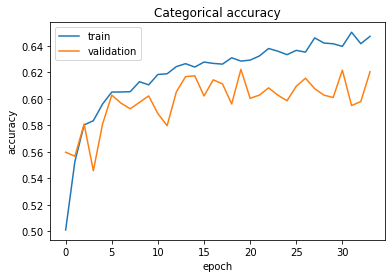

In [ ]:
plot_model_performance(vggnet16_trainableFalse_history)

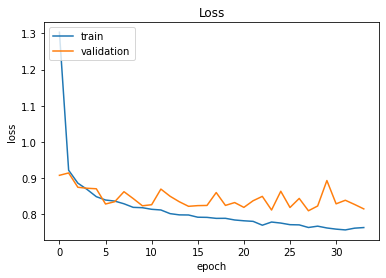

In [ ]:
plot_model_performance(vggnet16_trainableFalse_history)

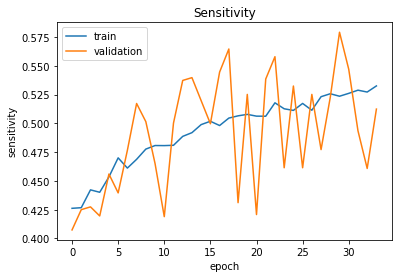

In [ ]:
plot_model_performance(vggnet16_trainableFalse_history)

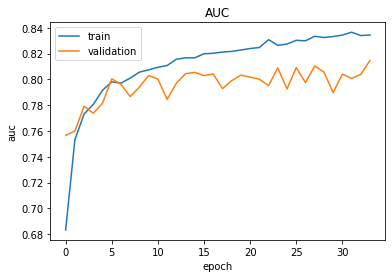

In [ ]:
plot_model_performance(vggnet16_trainableFalse_history)

In [ ]:
vggnet16_trainableFalse_history = train_model(
    model=vggnet16_model,
    train_dataset=train_datagen,
    validation_dataset=validation_datagen,
    output_model_name='vggnet16_trainableFalse_model',
    outputs_dir=os.path.join(outputs_dir, 'vggnet16_trainableFalse'),
    save_model_checkpoint=SaveModelCheckpoint(
        outputs_dir+'/vggnet16_trainableFalse/save_model_checkpoints/best_model.hdf5',
        prev_best=0.83962
    ),
    epochs=200,
    batch_size=batch_size,
    initial_value_threshold=0.83962
)

Epoch 1/200
464/464 [==============================] - ETA: 0s - loss: 1.2856 - categorical_accuracy: 0.4989 - auc: 0.6779 - sensitivity: 0.4195 - macro_specificity: 0.8107
Epoch 00001: val_loss improved from inf to 0.90928, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/save_model_checkpoints/best_model.hdf5

Epoch 1: val_loss improved from inf to 0.90928, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/vggnet16_trainableFalse_model/checkpoint


464/464 [==============================] - 589s 1s/step - loss: 1.2856 - categorical_accuracy: 0.4989 - auc: 0.6779 - sensitivity: 0.4195 - macro_specificity: 0.8107 - val_loss: 0.9093 - val_categorical_accuracy: 0.5628 - val_auc: 0.7592 - val_sensitivity: 0.4347 - val_macro_specificity: nan - lr: 1.0000e-04
Epoch 2/200
464/464 [==============================] - ETA: 0s - loss: 0.9359 - categorical_accuracy: 0.5486 - auc: 0.7474 - sensitivity: 0.4238 - macro_specificity: 0.8642
Epoch 00002: val_loss improved from 0.90928 to 0.90345, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/save_model_checkpoints/best_model.hdf5

Epoch 2: val_loss improved from 0.90928 to 0.90345, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/vggnet16_trainableFalse_model/checkpoint


464/464 [==============================] - 547s 1s/step - loss: 0.9359 - categorical_accuracy: 0.5486 - auc: 0.7474 - sensitivity: 0.4238 - macro_specificity: 0.8642 - val_loss: 0.9034 - val_categorical_accuracy: 0.5659 - val_auc: 0.7618 - val_sensitivity: 0.4621 - val_macro_specificity: nan - lr: 1.0000e-04
Epoch 3/200
464/464 [==============================] - ETA: 0s - loss: 0.8930 - categorical_accuracy: 0.5664 - auc: 0.7689 - sensitivity: 0.4411 - macro_specificity: 0.8748
Epoch 00003: val_loss improved from 0.90345 to 0.89390, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/save_model_checkpoints/best_model.hdf5

Epoch 3: val_loss improved from 0.90345 to 0.89390, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/vggnet16_trainableFalse_model/checkpoint


464/464 [==============================] - 551s 1s/step - loss: 0.8930 - categorical_accuracy: 0.5664 - auc: 0.7689 - sensitivity: 0.4411 - macro_specificity: 0.8748 - val_loss: 0.8939 - val_categorical_accuracy: 0.5968 - val_auc: 0.7778 - val_sensitivity: 0.5082 - val_macro_specificity: nan - lr: 1.0000e-04
Epoch 4/200
464/464 [==============================] - ETA: 0s - loss: 0.8748 - categorical_accuracy: 0.5789 - auc: 0.7780 - sensitivity: 0.4573 - macro_specificity: 0.8753
Epoch 00004: val_loss improved from 0.89390 to 0.87302, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/save_model_checkpoints/best_model.hdf5

Epoch 4: val_loss improved from 0.89390 to 0.87302, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/vggnet16_trainableFalse_model/checkpoint


464/464 [==============================] - 569s 1s/step - loss: 0.8748 - categorical_accuracy: 0.5789 - auc: 0.7780 - sensitivity: 0.4573 - macro_specificity: 0.8753 - val_loss: 0.8730 - val_categorical_accuracy: 0.5829 - val_auc: 0.7790 - val_sensitivity: 0.4529 - val_macro_specificity: nan - lr: 1.0000e-04
Epoch 5/200
464/464 [==============================] - ETA: 0s - loss: 0.8556 - categorical_accuracy: 0.5908 - auc: 0.7880 - sensitivity: 0.4617 - macro_specificity: 0.8831
Epoch 00005: val_loss improved from 0.87302 to 0.86797, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/save_model_checkpoints/best_model.hdf5

Epoch 5: val_loss improved from 0.87302 to 0.86797, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/vggnet16_trainableFalse_model/checkpoint


464/464 [==============================] - 520s 1s/step - loss: 0.8556 - categorical_accuracy: 0.5908 - auc: 0.7880 - sensitivity: 0.4617 - macro_specificity: 0.8831 - val_loss: 0.8680 - val_categorical_accuracy: 0.5974 - val_auc: 0.7883 - val_sensitivity: 0.5064 - val_macro_specificity: nan - lr: 1.0000e-04
Epoch 6/200
464/464 [==============================] - ETA: 0s - loss: 0.8488 - categorical_accuracy: 0.6002 - auc: 0.7928 - sensitivity: 0.4693 - macro_specificity: 0.8845
Epoch 00006: val_loss improved from 0.86797 to 0.84548, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/save_model_checkpoints/best_model.hdf5

Epoch 6: val_loss improved from 0.86797 to 0.84548, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/vggnet16_trainableFalse_model/checkpoint


464/464 [==============================] - 528s 1s/step - loss: 0.8488 - categorical_accuracy: 0.6002 - auc: 0.7928 - sensitivity: 0.4693 - macro_specificity: 0.8845 - val_loss: 0.8455 - val_categorical_accuracy: 0.5950 - val_auc: 0.7952 - val_sensitivity: 0.4912 - val_macro_specificity: nan - lr: 1.0000e-04
Epoch 7/200
464/464 [==============================] - ETA: 0s - loss: 0.8425 - categorical_accuracy: 0.6000 - auc: 0.7952 - sensitivity: 0.4674 - macro_specificity: 0.8855
Epoch 00007: val_loss improved from 0.84548 to 0.83962, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/save_model_checkpoints/best_model.hdf5

Epoch 7: val_loss improved from 0.84548 to 0.83962, saving model to /content/drive/MyDrive/Colab Notebooks/outputs/vggnet16_trainableFalse/vggnet16_trainableFalse_model/checkpoint


464/464 [==============================] - 538s 1s/step - loss: 0.8425 - categorical_accuracy: 0.6000 - auc: 0.7952 - sensitivity: 0.4674 - macro_specificity: 0.8855 - val_loss: 0.8396 - val_categorical_accuracy: 0.5981 - val_auc: 0.7982 - val_sensitivity: 0.4869 - val_macro_specificity: nan - lr: 1.0000e-04
Epoch 8/200
390/464 [========================>.....] - ETA: 1:14 - loss: 0.8276 - categorical_accuracy: 0.6092 - auc: 0.8040 - sensitivity: 0.4846 - macro_specificity: 0.8895

In [ ]:
def finetune_model(
    base_model, 
    is_trainable,
    model, 
    optimiser_with_learning_rate
):
    '''
    Builds a model using a base model and a new top layer
    '''
    # Freeze the base model
    base_model.trainable = is_trainable

    # Compile the model
    model.compile(
        optimizer=optimiser_with_learning_rate,
        loss=tf.keras.losses.CategoricalCrossentropy(), 
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy"), 
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Recall(name="sensitivity")
        ]
    )

    # Print summary
    print('========================= MODEL SUMMARY =========================')
    print(model.summary())

    return model

In [ ]:
# Load class image paths from npz file
dataset_unprocessed = np.load(os.path.join(root_dir, 'dataset_unprocessed.npz'), allow_pickle=True)

In [ ]:
def evaluate_model(model, test_dataset):
    '''
    Evaluates a model
    '''
    test_metrics = model.evaluate(
        test_dataset,
        workers=4,
        use_multiprocessing=True,
        return_dict=True
    )

    metric_names = model.metrics_names

    return test_metrics, metric_names

In [ ]:
def load_model(model_dir, folder_name='checkpoint'):
    model = tf.keras.models.load_model(os.path.join(model_dir, folder_name))

    return model

In [ ]:
# Train the ResNet50V2 model
resnet50V2_history = train_model(
    model=resnet50V2_model,
    train_dataset=train_dataset_prefetched,
    validation_dataset=validation_dataset_prefetched,
    output_model_name='resnet50_isTrainableFalse',
    outputs_dir=os.path.join(root_dir, 'resnet50'),
    save_model_checkpoint=SaveModelCheckpoint(outputs_dir+'save_model_checkpoints/model-sem21cm_ep{epoch:d}'),
    epochs=200,
    batch_size=batch_size
)

Epoch 1/200
464/464 [==============================] - ETA: 0s - loss: 0.9275 - categorical_accuracy: 0.5781 - auc: 0.7716 - sensitivity: 0.4497 - macro_specificity: 0.8791
Epoch 00001: val_loss improved from inf to 0.83458, saving model to /content/drive/MyDrive/Colab Notebooks/resnet50save_model_checkpoints/model-sem21cm_ep1

Epoch 1: val_loss improved from inf to 0.83458, saving model to /content/drive/MyDrive/Colab Notebooks/resnet50/resnet50_isTrainableFalse/checkpoint
464/464 [==============================] - 1579s 3s/step - loss: 0.9275 - categorical_accuracy: 0.5781 - auc: 0.7716 - sensitivity: 0.4497 - macro_specificity: 0.8791 - val_loss: 0.8346 - val_categorical_accuracy: 0.5914 - val_auc: 0.7996 - val_sensitivity: 0.4226 - val_macro_specificity: 0.9111 - lr: 0.0020
Epoch 2/200
464/464 [==============================] - ETA: 0s - loss: 0.8039 - categorical_accuracy: 0.6204 - auc: 0.8142 - sensitivity: 0.4890 - macro_specificity: 0.8911
Epoch 00002: val_loss improved from 0.